In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from seaborn import swarmplot
import os,itertools
import numpy as np
from IPython.display import HTML 
%matplotlib inline
import matplotlib as mpl


In [2]:
df = pd.read_csv(os.path.join(os.getcwd(), '../resources/accuracy_set.csv'), index_col=0, dtype={'input' : object, 'output': object})

drop_columns = ['Unnamed: 0', 'SynBioHub URI', 'Unnamed: 0.1', 'calibration_id', 'experiment_id', 'filename', 
                'glycerol_plate_index',  'growth_media_1', 'growth_media_2',  
                'inc_temp', 'inc_time_1', 'inc_time_2', 'input', 'lab', 'lab_id', 'media', 'od', 
                'od_cutoff', 'output', 'part_1_id', 'part_2_id', 'plate_id',  'replicate', 'source_container', 
                'strain_name', 'strain_circuit', 'well', 'post_well']
od_df = pd.read_csv(os.path.join(os.getcwd(), '../resources/tx_od.csv')).rename(columns={'strain' : 'strain_name'}).drop(columns=drop_columns)
df = df.merge(od_df, on='id', how='left')
discretization = [
          (0.0, 1e-4),
          (1e-4, 3e-4),
          (3e-4, 7e-4),
          (7e-4, 1e-3),
          (1e-3, 5.1e-3),
          (5.1e-3, 1.0)
      ]
means = [np.around(np.mean(d),5) for d in discretization]
means[-1] = 5.1e-3
recast = [means[i] for d in df["od"] for i,k in enumerate(discretization) if d > k[0] and d <= k[1] ]
df["od"] = recast

conditions=['inc_time_2', 'media', 'inc_temp', 'od']
design=['gate', 'input']


In [3]:
def strain_scores(correctness_col):
    strain_score_df = df.groupby(conditions+design)[correctness_col].agg(np.mean).reset_index()
    return strain_score_df
    

In [4]:
def hierarchical_means(correctness_col):
    strain_score_df = strain_scores(correctness_col)
    # Circuit x condition scores is product of strain for condition
    circuit_score_df_prod = strain_score_df.groupby(conditions+['gate'])[correctness_col].agg(np.prod).reset_index()
    conditions2=['media', 'inc_temp', 'od']
    circuit_score_df_prod_inc = circuit_score_df_prod.groupby(conditions2+['gate'])[correctness_col].agg(np.mean).reset_index()
    conditions3=['media', 'od']
    circuit_score_df_prod_inc_temp = circuit_score_df_prod_inc.groupby(conditions3+['gate'])[correctness_col].agg(np.mean).reset_index()
    circuit_score_df_prod_media_only = circuit_score_df_prod_inc_temp.groupby(['media','gate'])[correctness_col].agg(np.mean).reset_index()
    circuit_score_df_prod_media_only.sort_values(by=[correctness_col])
    overall_circuit_score_df_prod = circuit_score_df_prod_media_only.groupby(['gate'])[correctness_col].agg(np.mean).reset_index()
    circuit_robustness_df = circuit_score_df_prod_media_only.groupby(['gate'])[correctness_col].agg(np.std).reset_index()
    circuit_robustness_df.loc[:,"robustness"] = [1-c for c in circuit_robustness_df.loc[:,correctness_col]] 
    circuit_robustness_df = circuit_robustness_df.drop(columns=[correctness_col])
    return circuit_score_df_prod,overall_circuit_score_df_prod,circuit_robustness_df
    

In [5]:
def hierarchical_means_2(correctness_col):
    strain_score_df = strain_scores(correctness_col)
    # Circuit x condition scores is product of strain for condition
    circuit_score_df_prod = strain_score_df.groupby(conditions+['gate'])[correctness_col].agg(np.prod).reset_index()
    conditions2=['media', 'inc_temp', 'od']
    circuit_score_df_prod_inc = circuit_score_df_prod.groupby(conditions2+['gate'])[correctness_col].agg(np.mean).reset_index()
    conditions3=['media', 'inc_temp']
    circuit_score_df_prod_inc_temp = circuit_score_df_prod_inc.groupby(conditions3+['gate'])[correctness_col].agg(np.mean).reset_index()
    circuit_score_df_prod_media_only = circuit_score_df_prod_inc_temp.groupby(['media','gate'])[correctness_col].agg(np.mean).reset_index()
    circuit_score_df_prod_media_only.sort_values(by=[correctness_col])
    overall_circuit_score_df_prod = circuit_score_df_prod_media_only.groupby(['gate'])[correctness_col].agg(np.mean).reset_index()
    circuit_robustness_df = circuit_score_df_prod_media_only.groupby(['gate'])[correctness_col].agg(np.std).reset_index()
    circuit_robustness_df.loc[:,"robustness"] = [1-c for c in circuit_robustness_df.loc[:,correctness_col]] 
    circuit_robustness_df = circuit_robustness_df.drop(columns=[correctness_col])
    return circuit_score_df_prod,overall_circuit_score_df_prod,circuit_robustness_df
    

In [6]:
mpl.rcParams['figure.dpi']= 600

def get_vals(df_prod,correctness_col):
    data30_sc = df_prod.loc[(df_prod.inc_temp==30.0) & (df_prod.media=="standard_media")][correctness_col].values
    data30_osm = df_prod.loc[(df_prod.inc_temp==30.0) & (df_prod.media=="high_osm_media")][correctness_col].values
    data30_slow = df_prod.loc[(df_prod.inc_temp==30.0) & (df_prod.media=="slow_media")][correctness_col].values
    data37_sc = df_prod.loc[(df_prod.inc_temp==37.0) & (df_prod.media=="standard_media")][correctness_col].values
    data37_osm = df_prod.loc[(df_prod.inc_temp==37.0) & (df_prod.media=="high_osm_media")][correctness_col].values
    data37_slow = df_prod.loc[(df_prod.inc_temp==37.0) & (df_prod.media=="slow_media")][correctness_col].values
    return [data30_sc,data30_osm,data30_slow,data37_sc,data37_osm,data37_slow]


def calculate_stats(data):
    err = []
    medians = []
    stds = []
    for ds in data:
        s = np.std(ds)
        stds.append(s)
        err.append(s / np.sqrt(len(ds)))
        medians.append(np.median(ds))
    return err,stds,medians

# make error bar plots
def whisker(gate,correctness_col,df):
    plt.figure()
    df_prod = df[(df["gate"]==gate)]
    datasc=get_vals(df_prod,correctness_col)
    err,stds,medians = calculate_stats(datasc)
    print([z for z in zip(["SC30","OSM30","SLOW30","SC37","OSM37","SLOW37"],zip(stds,err))])
    plt.boxplot(datasc,patch_artist=True,boxprops=dict(facecolor="lightgray"))
    labels = list(y+"\n"+str(x) for x,y in itertools.product([30.0,37.0],["SC Media","High Osm","SC Slow"]))
    plt.xticks(range(1,7), labels, fontsize=10)
    plt.xlim((0.5,6.5))
    plt.ylim((-0.1,1))
    plt.ylabel("Correctness") 
    return medians
    

In [19]:
def make_all_dfs(correctness_columns):
    dfs = []
    for col in correctness_columns:
        print(col)
        df,overall_circuit_score_df_prod,circuit_robustness_df = hierarchical_means(col)
        dfs.append(df)
        display(HTML(overall_circuit_score_df_prod.sort_values(by=[col],ascending=False).to_html(index=False)))
        display(HTML(circuit_robustness_df.sort_values(by=['robustness'],ascending=False).to_html(index=False)))
    return dfs
        

In [8]:
def do_a_gate(gate,correctness_columns,dfs):
    medians = []
    for col,df in zip(correctness_columns,dfs):
        medians.append(whisker(gate,col,df))
    return medians

In [9]:
def compare_medians(col1,col2,cutoff):
    newcol1,newcol2 = [],[]
    for k,(c1,c2) in enumerate(zip(col1,col2)):
        if not np.isnan(c1) and not np.isnan(c2):
            newcol1.append(c1)
            newcol2.append(c2)
    lessthan = sum([m1-m2 >= cutoff for m1,m2 in zip(newcol1,newcol2)])/len(newcol1)
    greaterthan = sum([m1-m2 < 0 for m1,m2 in zip(newcol1,newcol2)])/len(newcol1)
    return lessthan,greaterthan

In [20]:
correctness_columns = ['mean_correct_classifier_live','mean_correct_threshold_live']
dfs = make_all_dfs(correctness_columns)


mean_correct_classifier_live


gate,mean_correct_classifier_live
AND,0.543478
NOR,0.477455
XNOR,0.316413
NAND,0.273144
XOR,0.171044
OR,0.003670


gate,robustness
OR,0.998122
XOR,0.980576
AND,0.915541
NOR,0.901406
XNOR,0.874539
NAND,0.860931


mean_correct_threshold_live


gate,mean_correct_threshold_live
AND,0.437993
NOR,0.280525
XNOR,0.238959
NAND,0.214875
XOR,0.107566
OR,0.026632


gate,robustness
OR,0.991951
AND,0.984026
XOR,0.980194
NOR,0.969792
NAND,0.949486
XNOR,0.872759


AND
[('SC30', (0.1616825911536075, 0.029039050616615242)), ('OSM30', (0.047170339520560794, 0.033354466945860334)), ('SLOW30', (0.0230145004622041, 0.01627370934244545)), ('SC37', (0.08393124000790944, 0.037535191618707095)), ('OSM37', (0.05004916654229863, 0.03539010505479423)), ('SLOW37', (0.015161447529563568, 0.010720762360758427))]
[('SC30', (0.1615518675372322, 0.02901557196201412)), ('OSM30', (0.019731053949572586, 0.013951962047700385)), ('SLOW30', (0.024076121883664148, 0.01702438904861275)), ('SC37', (0.042046512065296, 0.018803771838953386)), ('OSM37', (0.022462762783040963, 0.01588357188807307)), ('SLOW37', (0.020297483615236367, 0.014352488305356475))]
Percent of threshold median at least 0.0 below classifier median: 0.6666666666666666.
Percent of threshold median above classifier median: 0.3333333333333333.


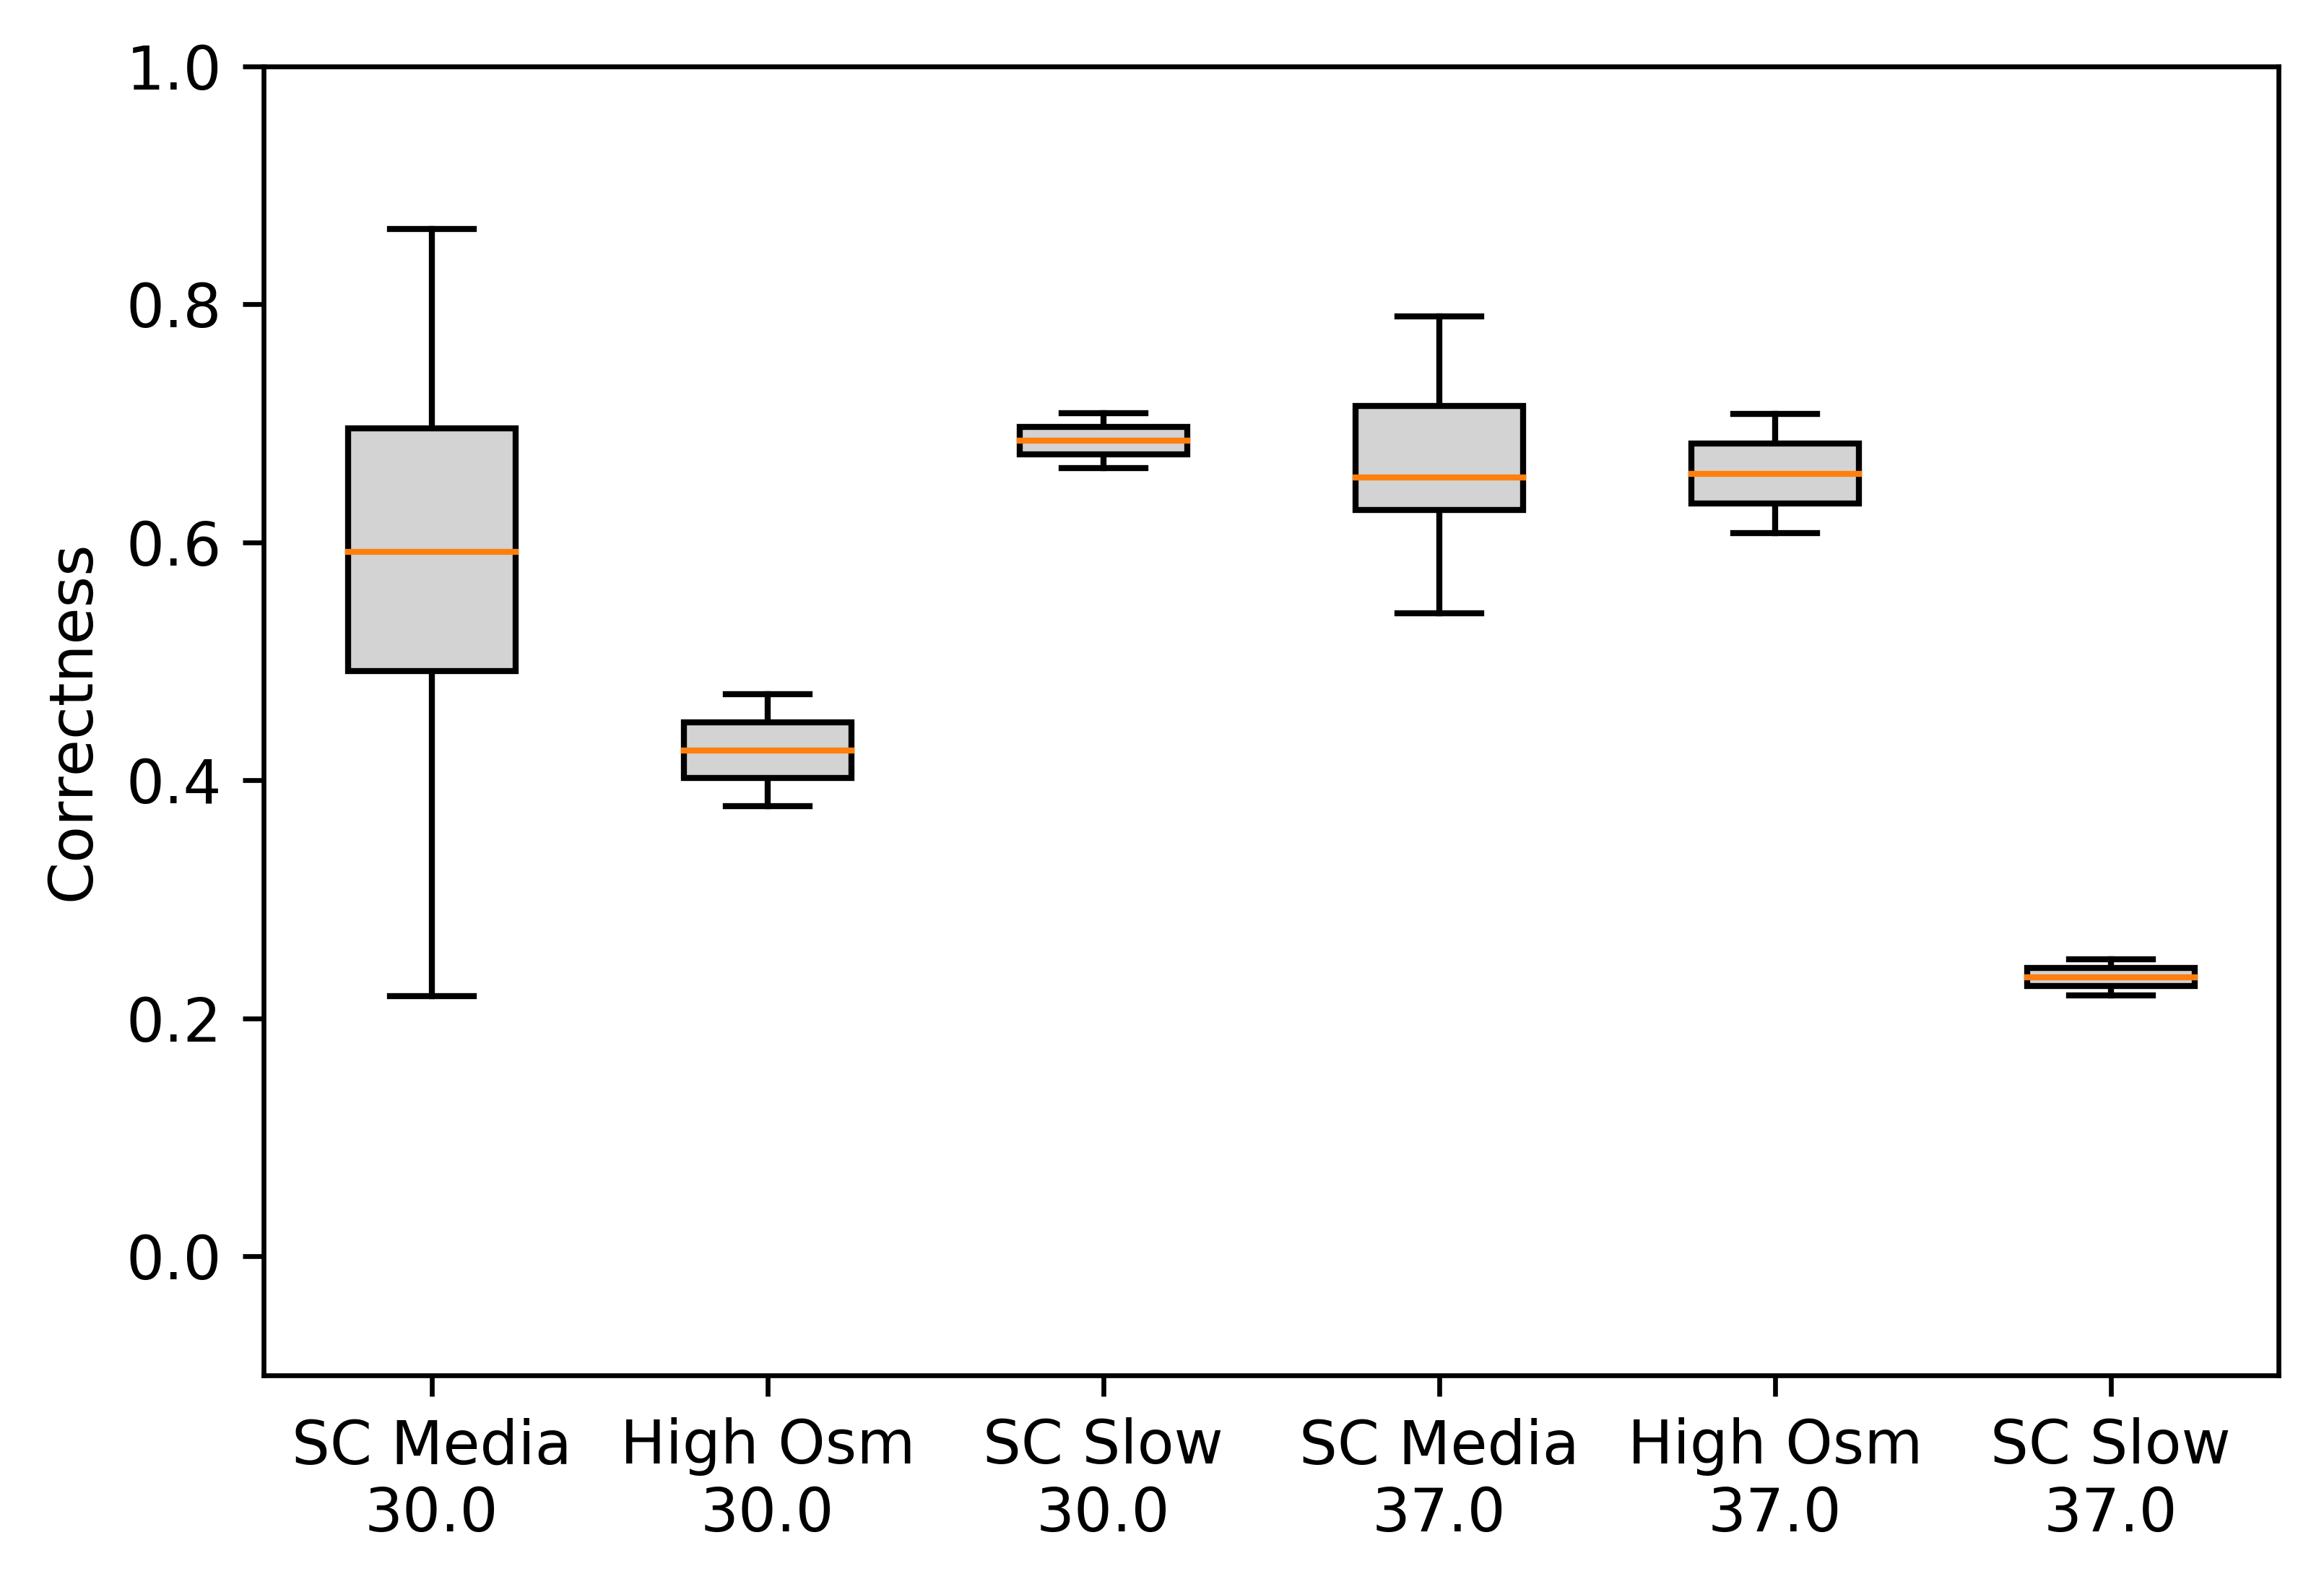

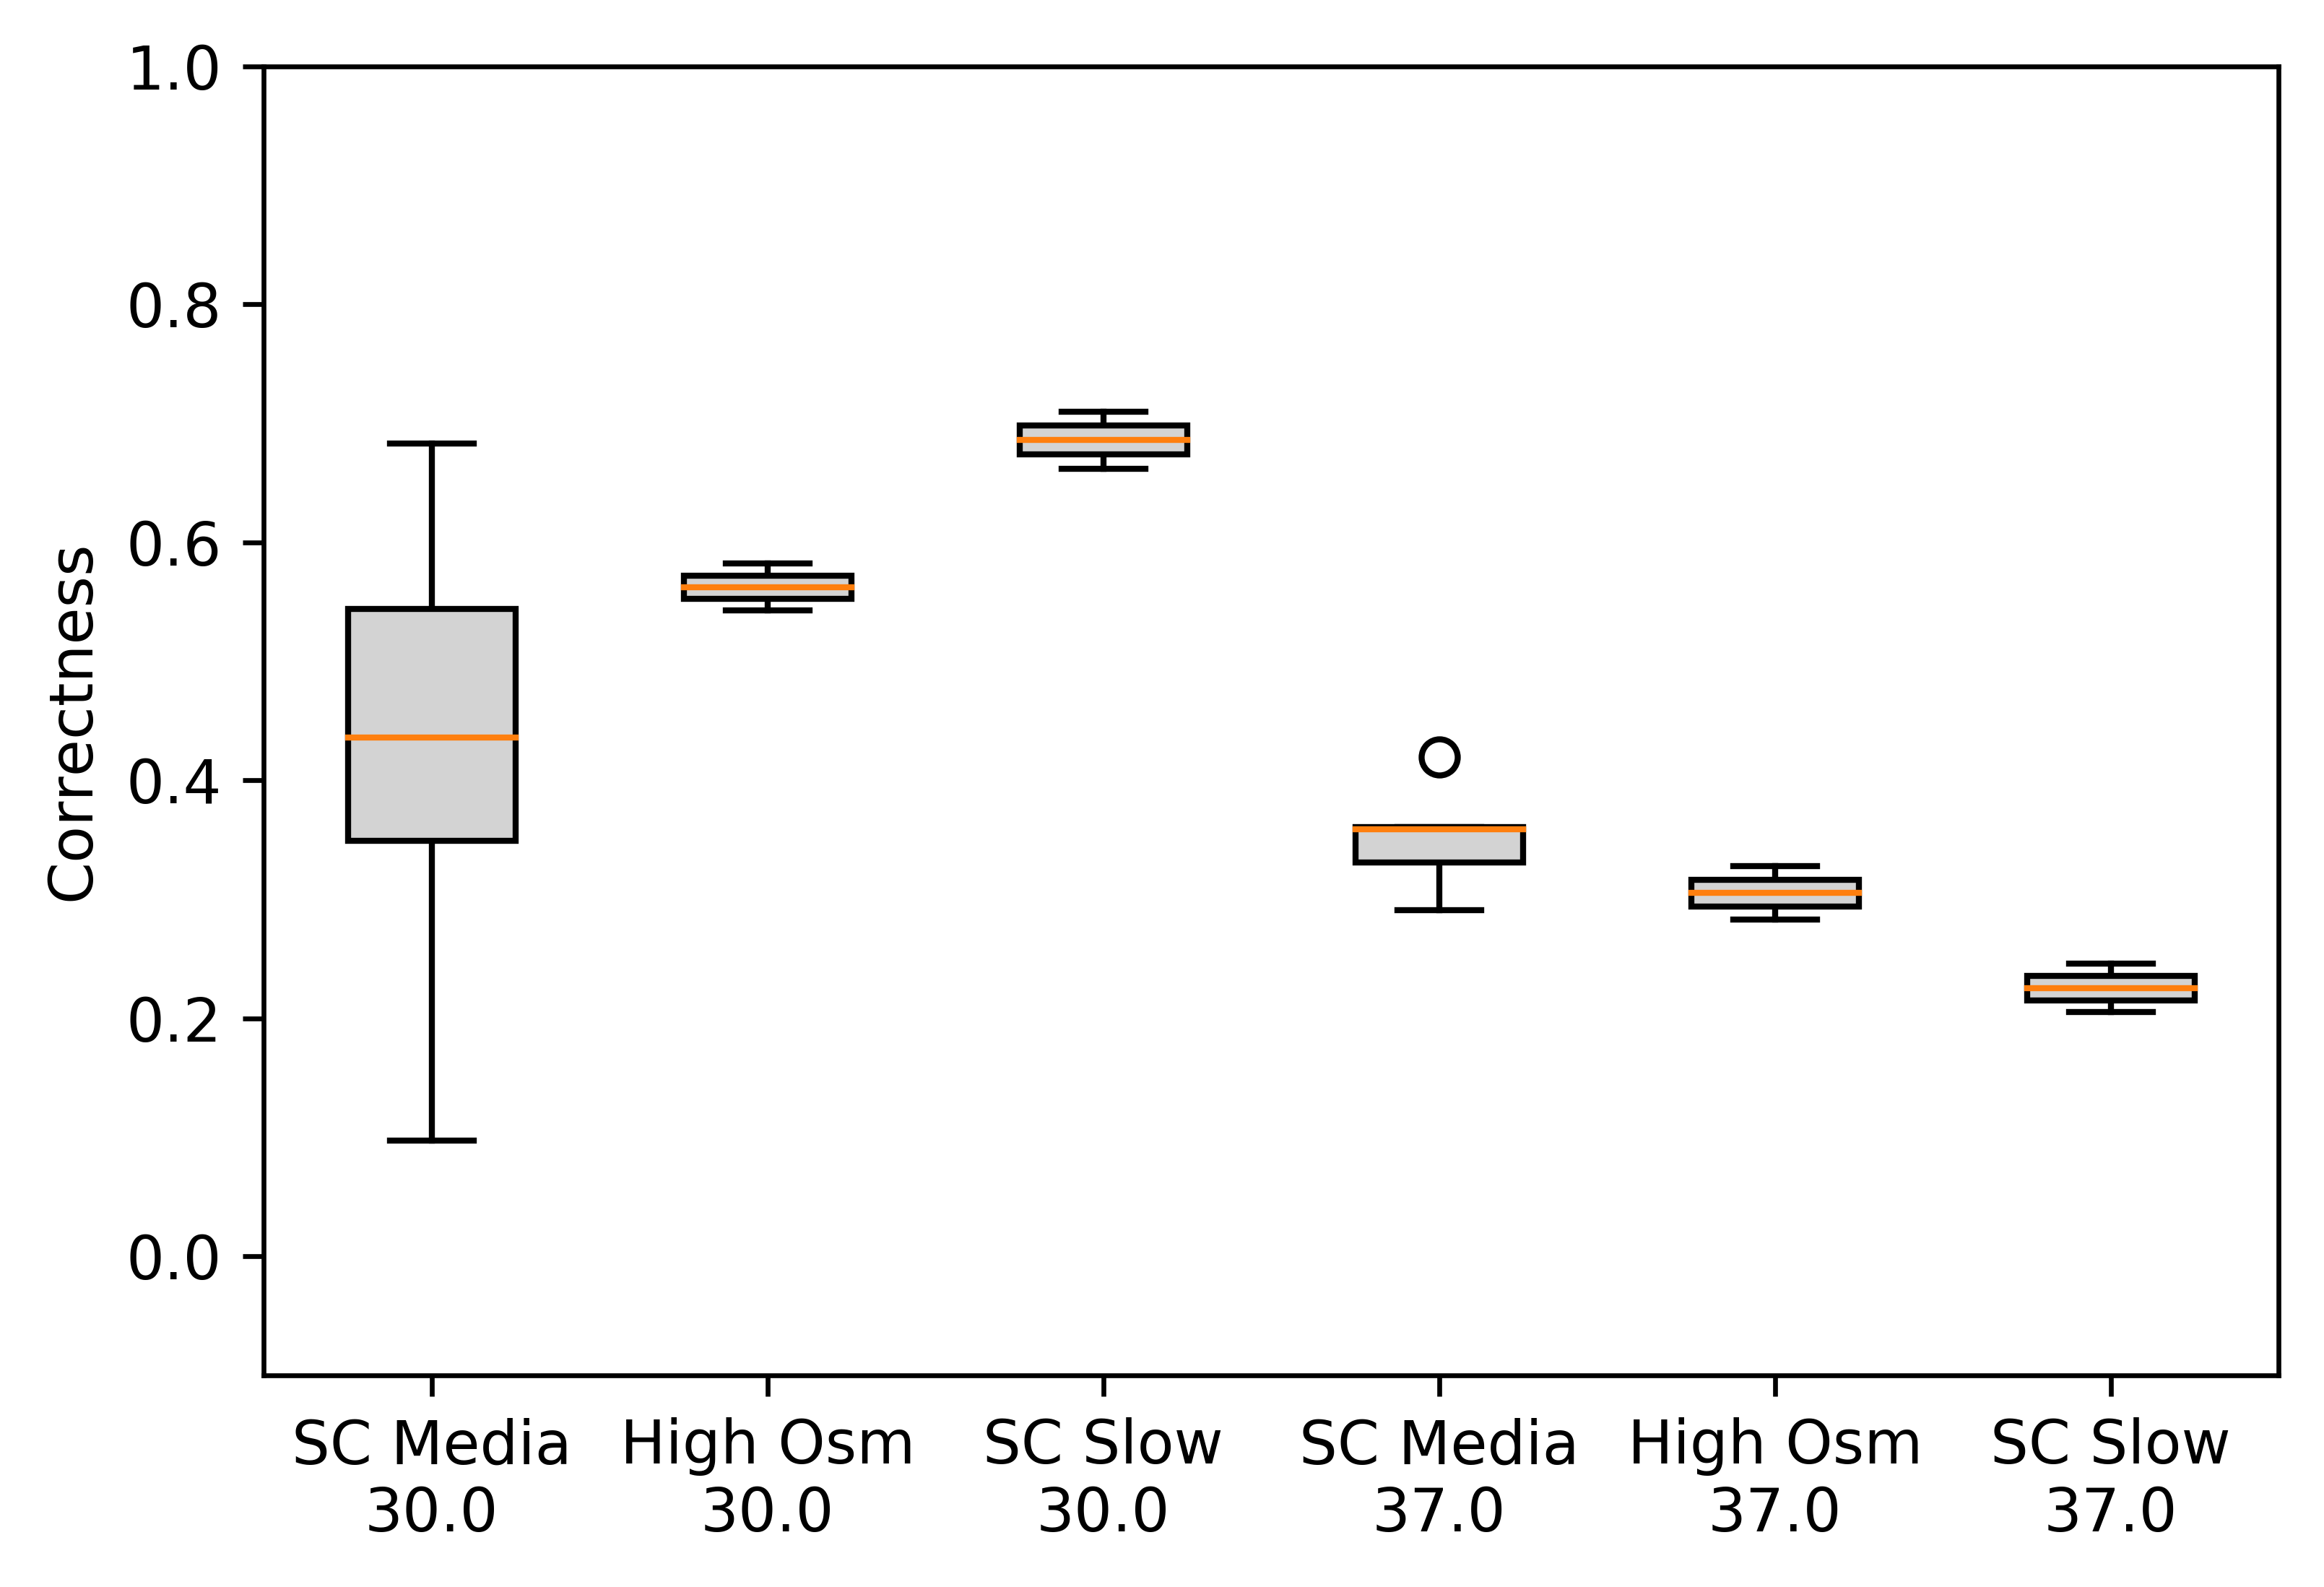

In [11]:
print("AND")
medians = do_a_gate("AND",correctness_columns,dfs)
cutoff=0.0
lt,gt = compare_medians(medians[0],medians[1],cutoff)
print("Percent of threshold median at least {} below classifier median: {}.".format(cutoff,lt))
print("Percent of threshold median above classifier median: {}.".format(gt))


NAND
[('SC30', (0.10288558874135939, 0.018478797240094404)), ('OSM30', (0.0006115727652151459, 0.00043244724947263794)), ('SLOW30', (0.013426161221789787, 0.00949372964523142)), ('SC37', (0.20520778744302762, 0.0917717124469875)), ('OSM37', (0.033033679919507314, 0.023358339078629504)), ('SLOW37', (0.002296572978307057, 0.001623922326450706))]
[('SC30', (0.08798797897427729, 0.015803107538400595)), ('OSM30', (0.010709808732655798, 0.007572978380071819)), ('SLOW30', (0.013066306482817147, 0.009239273919061751)), ('SC37', (0.08174616265024016, 0.03655799531713827)), ('OSM37', (0.021353930095180926, 0.01509950877528593)), ('SLOW37', (0.011317860741493185, 0.008002936078834838))]
Percent of threshold median at least 0.0 below classifier median: 0.6666666666666666.
Percent of threshold median above classifier median: 0.3333333333333333.


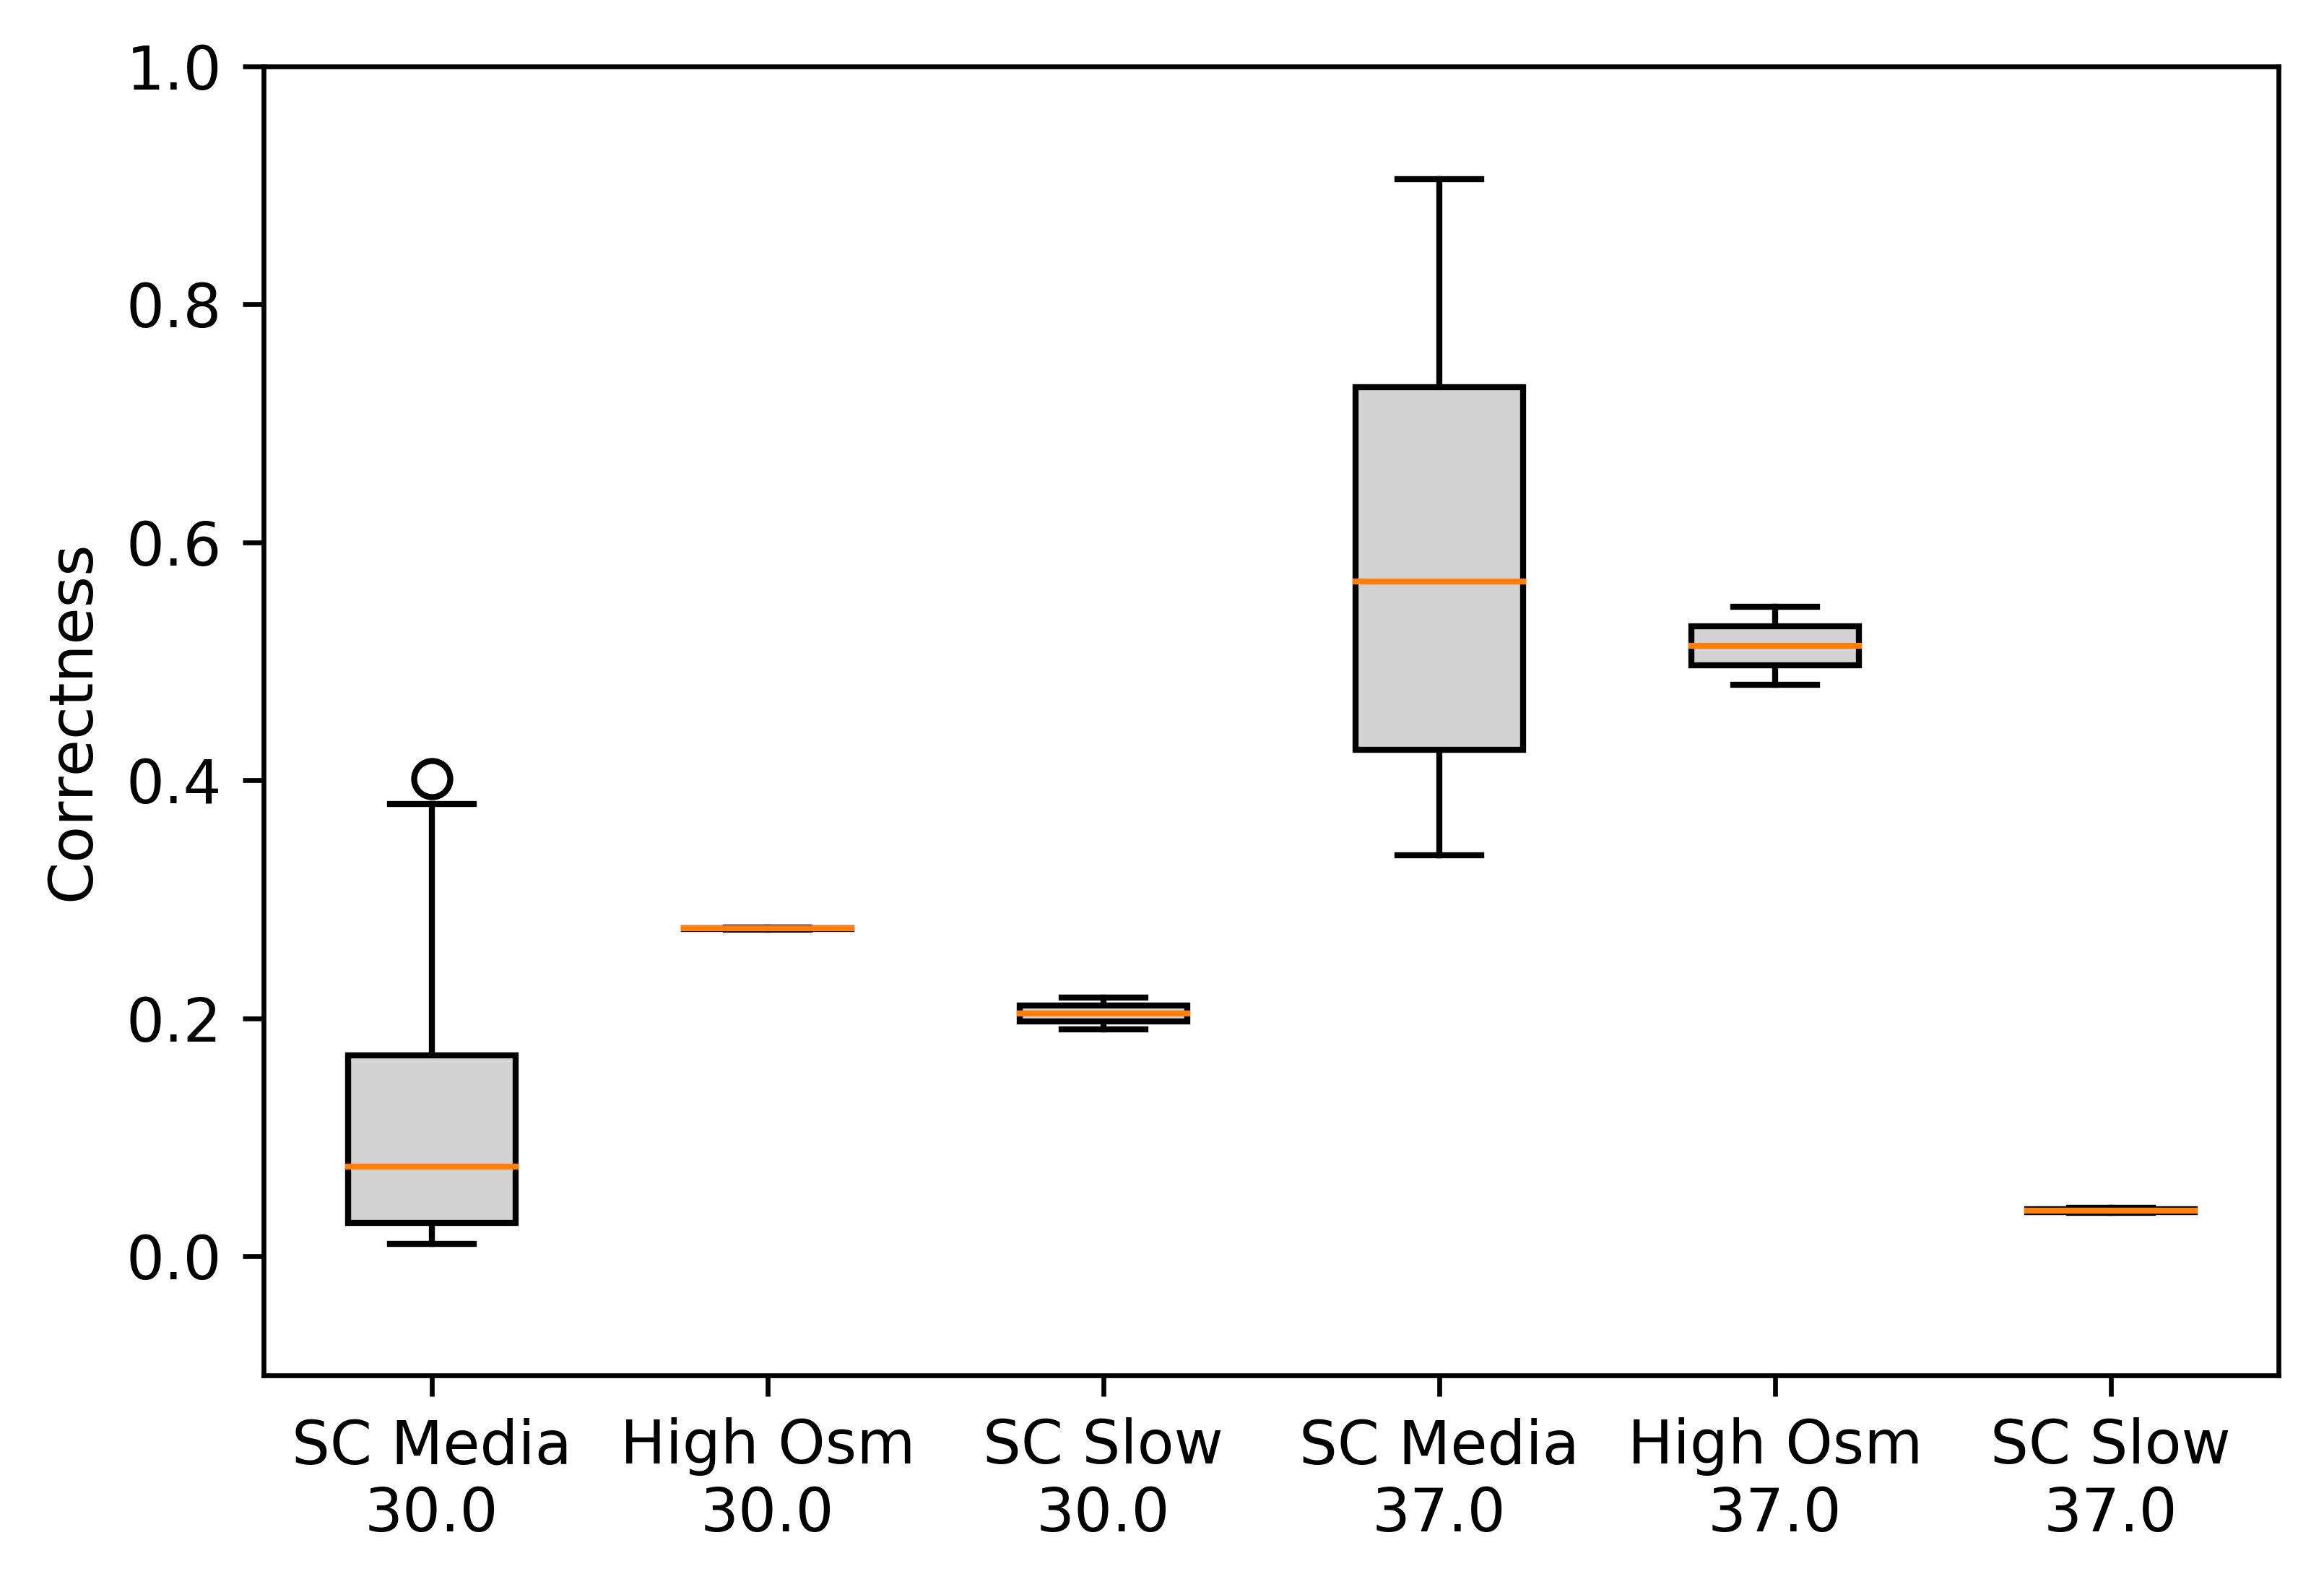

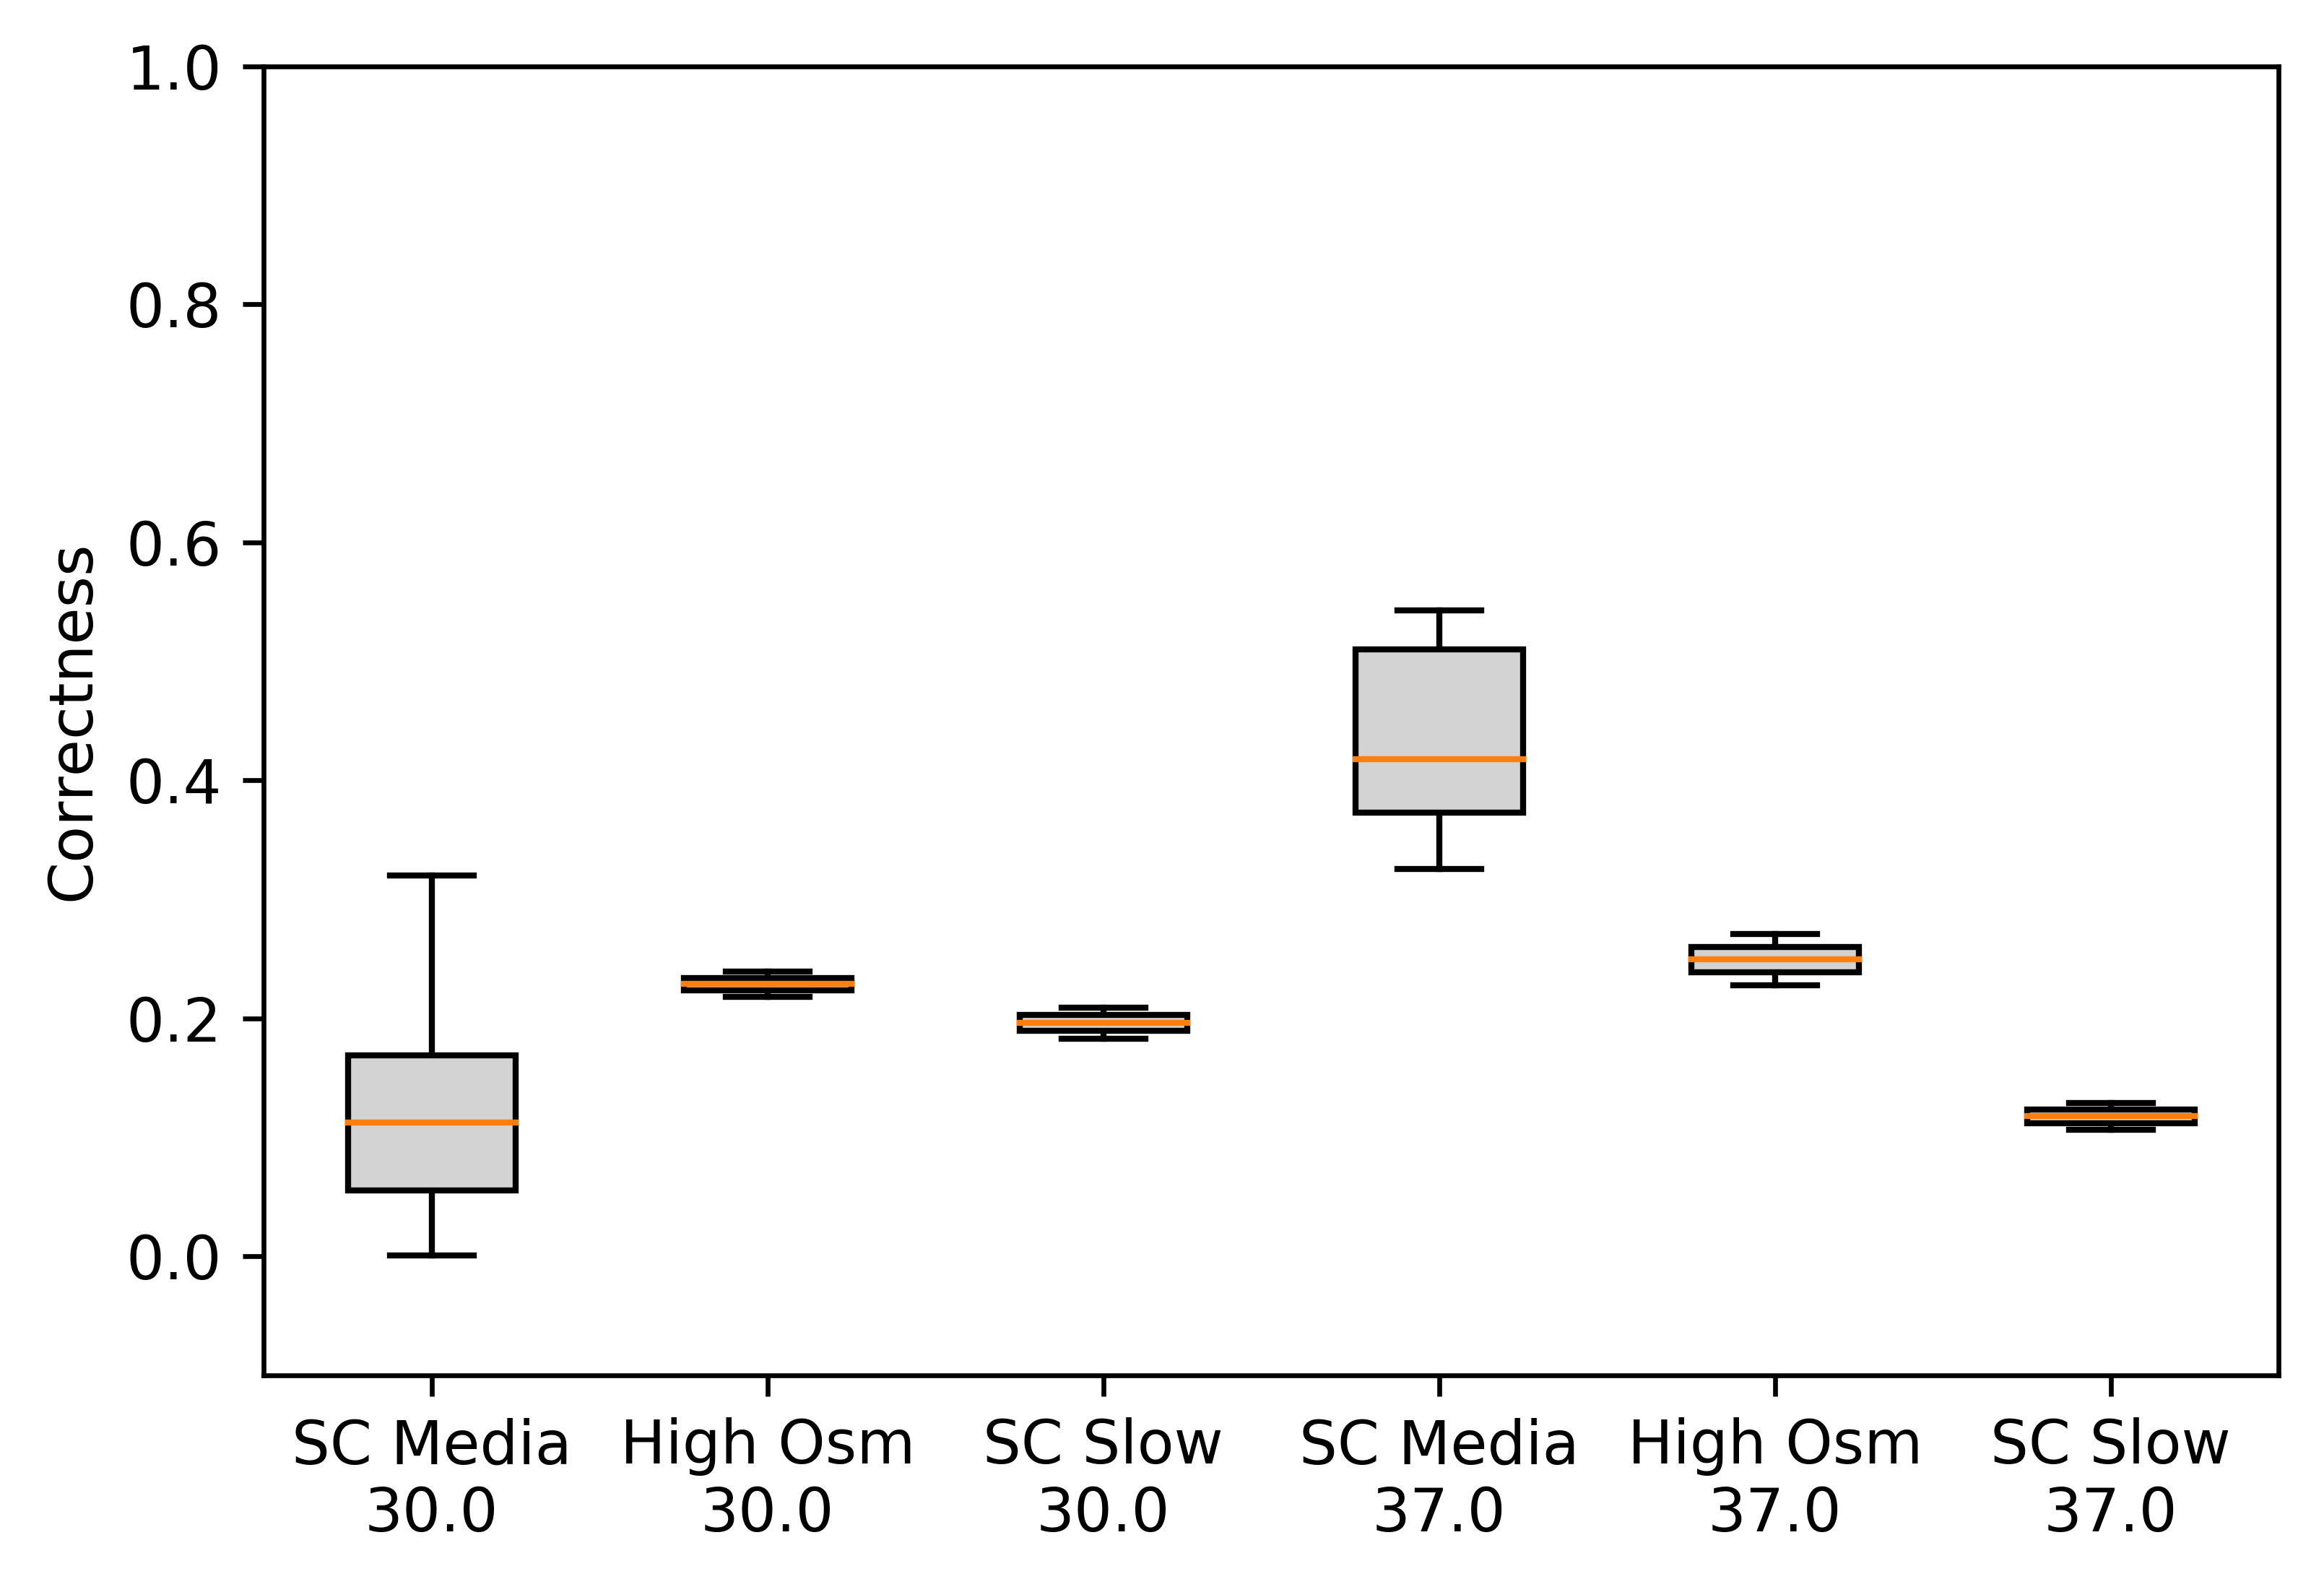

In [12]:
print("NAND")
medians = do_a_gate("NAND",correctness_columns,dfs)
cutoff=0.0
lt,gt = compare_medians(medians[0],medians[1],cutoff)
print("Percent of threshold median at least {} below classifier median: {}.".format(cutoff,lt))
print("Percent of threshold median above classifier median: {}.".format(gt))


OR
[('SC30', (0.013509690155360892, 0.002426411980641741)), ('OSM30', (6.970979523701484e-05, 4.929226892721888e-05)), ('SLOW30', (0.0006512837299461902, 0.0004605271419214192)), ('SC37', (0.00042231770540236056, 0.00018886621947628168)), ('OSM37', (0.0013903205980364442, 0.0009831051228949058)), ('SLOW37', (0.0008258759000832139, 0.000583982449367384))]
[('SC30', (0.033894913033108626, 0.006087706092482744)), ('OSM30', (0.0021635452410748435, 0.0015298575113679054)), ('SLOW30', (0.0009894856904549528, 0.0006996720416077502)), ('SC37', (0.007284325976880601, 0.003257649610914517)), ('OSM37', (0.002099957929644798, 0.0014848944922582995)), ('SLOW37', (0.0026782107316168785, 0.0018937809697728793))]
Percent of threshold median at least 0.0 below classifier median: 0.0.
Percent of threshold median above classifier median: 1.0.


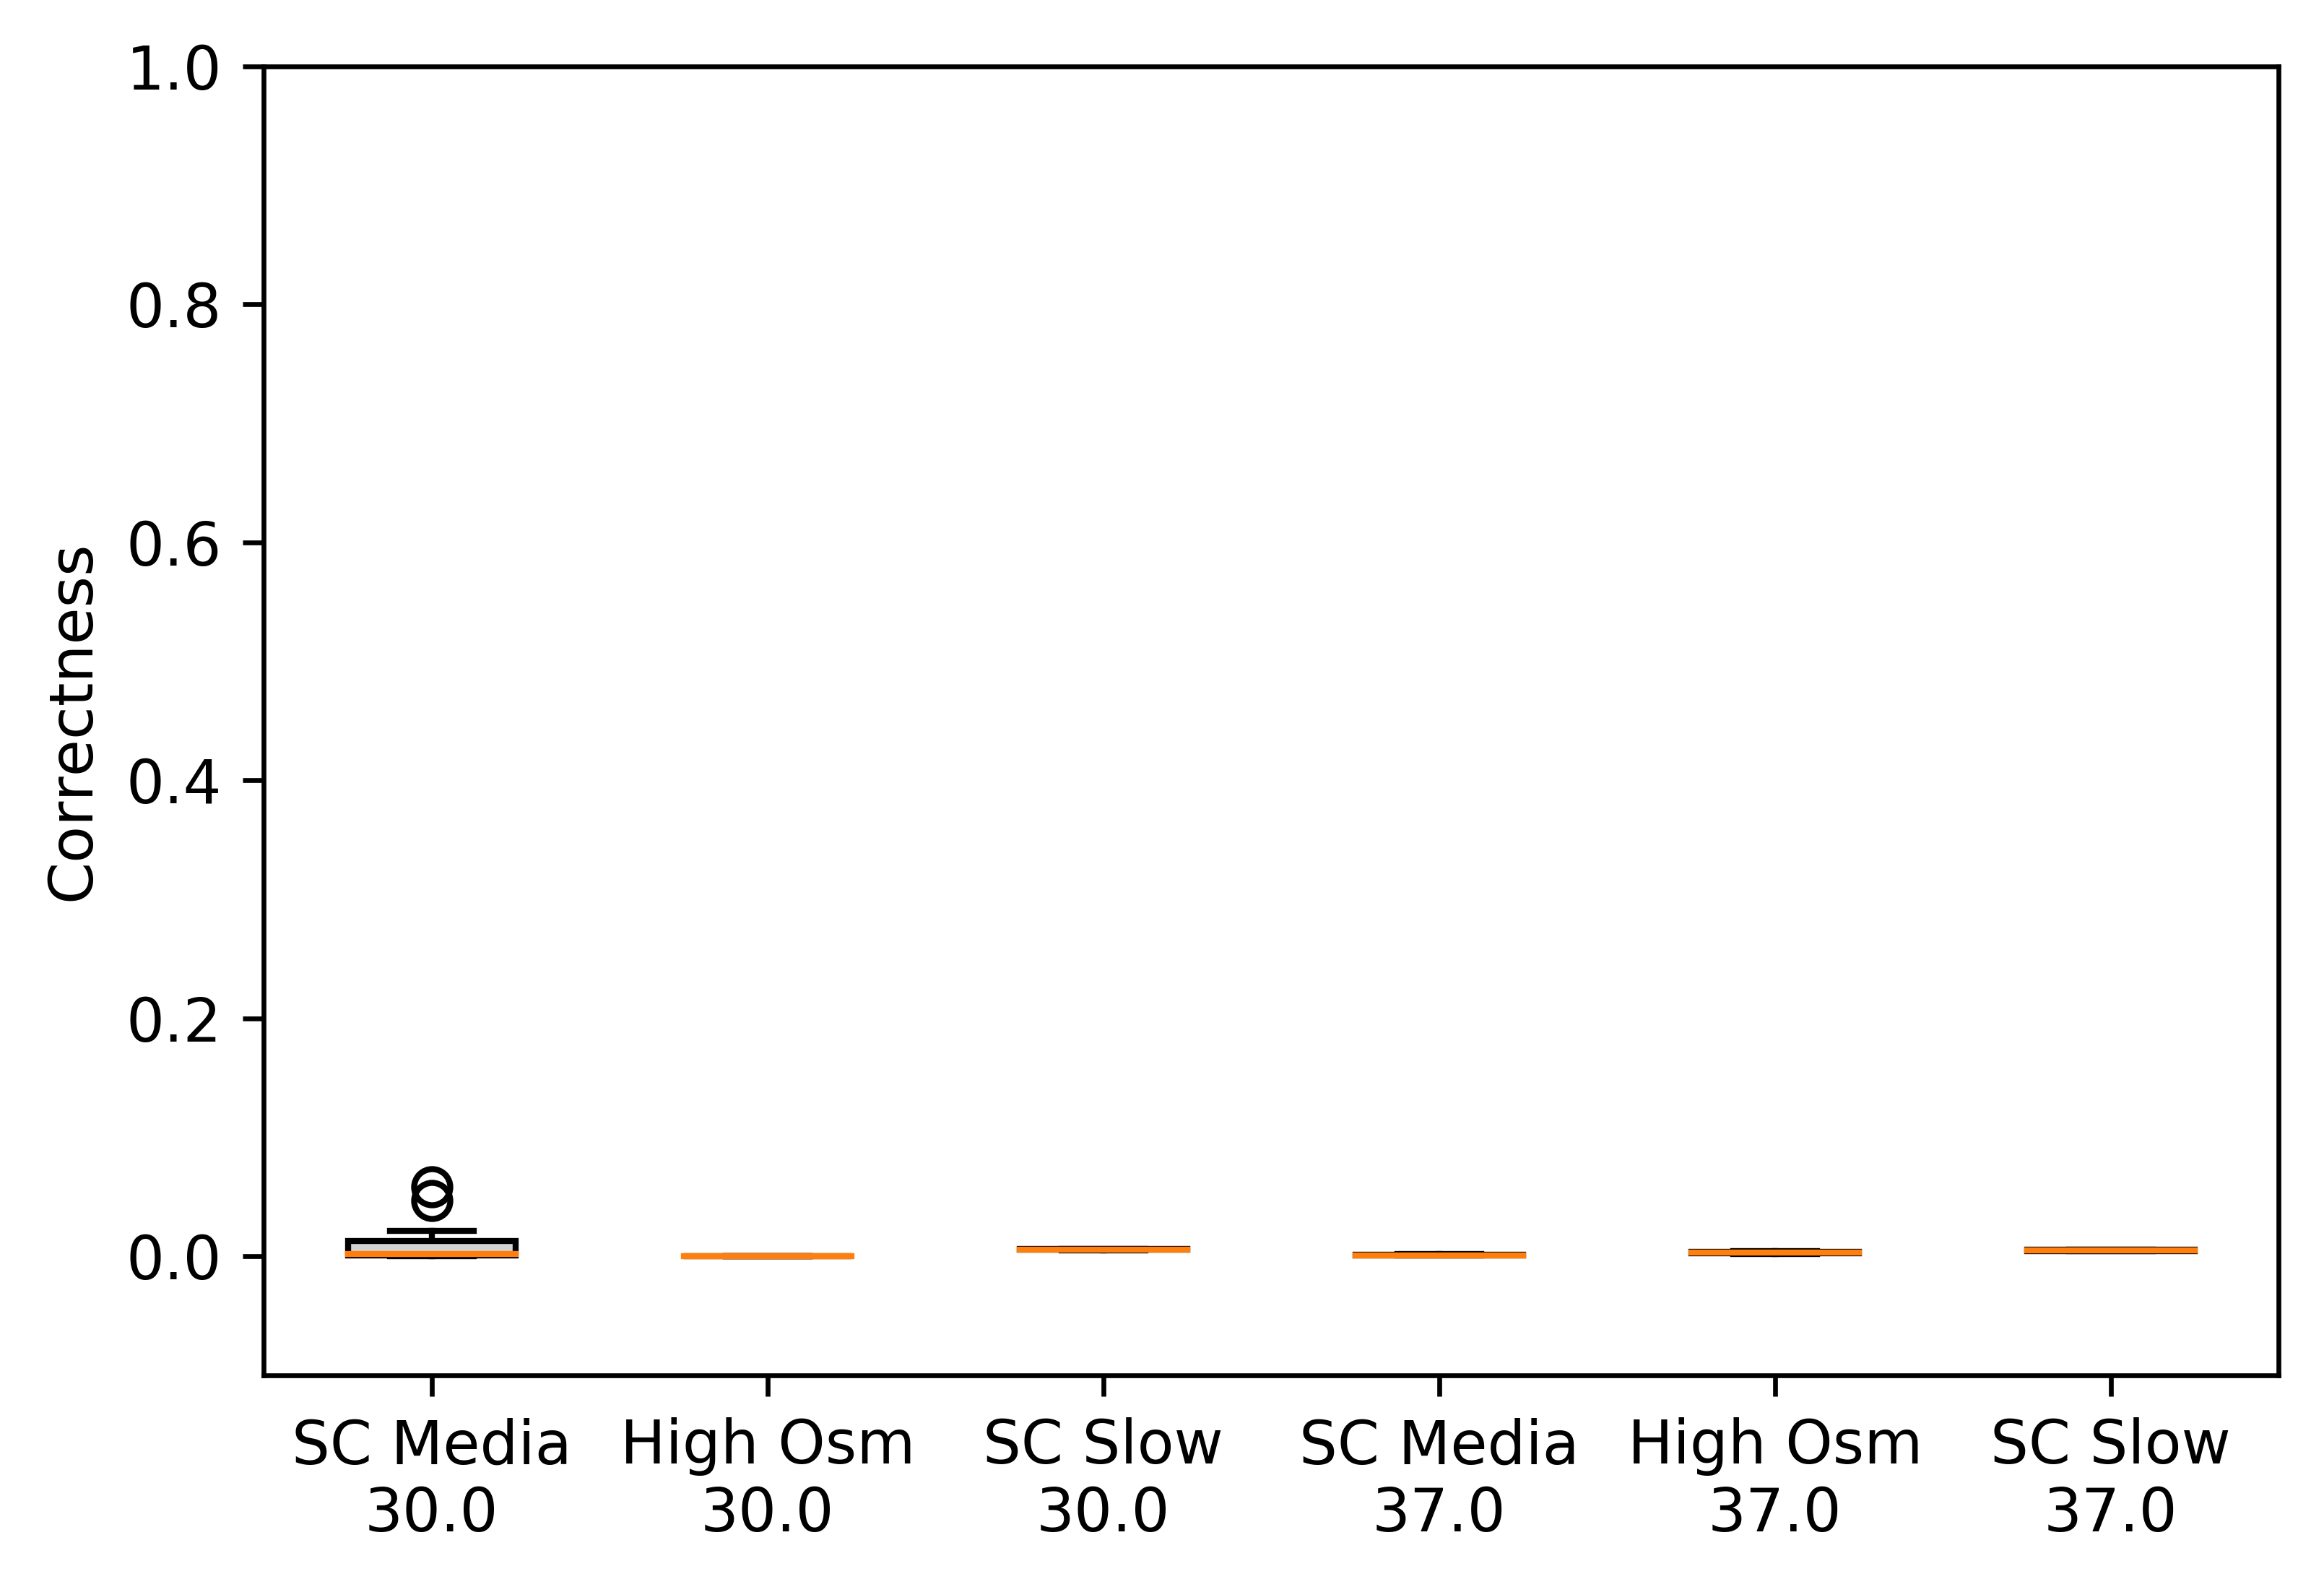

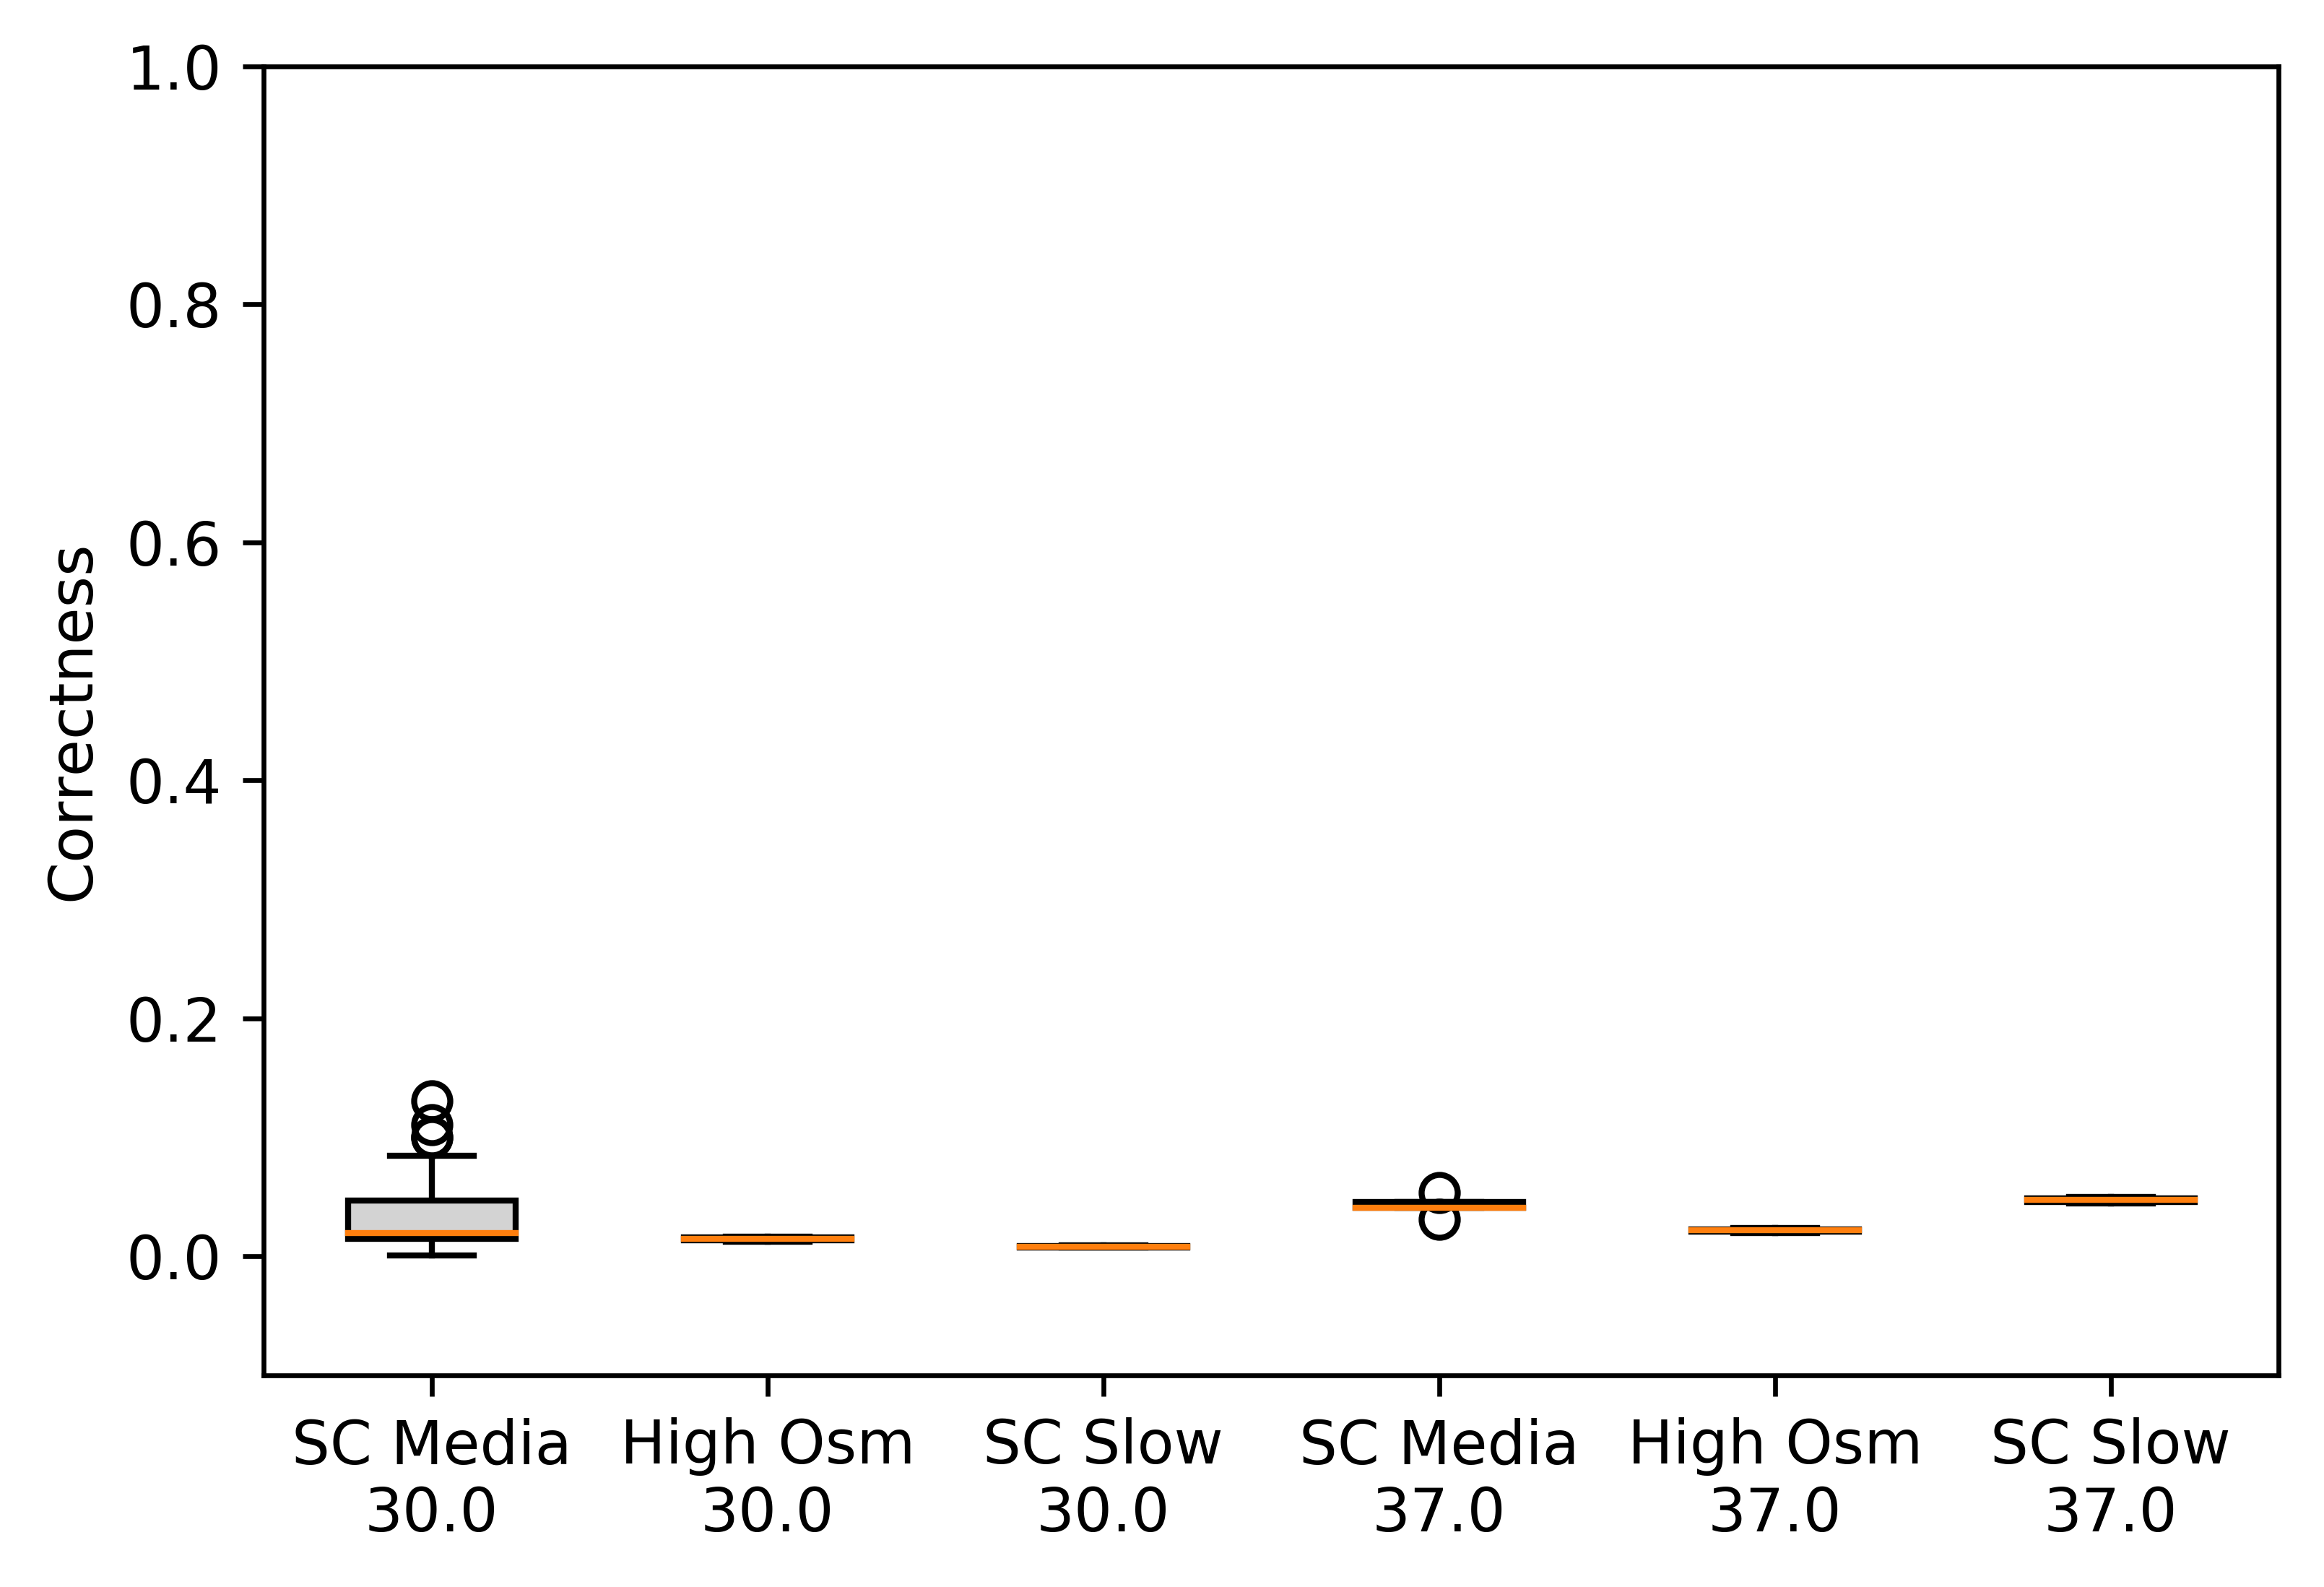

In [13]:
print("OR")
medians = do_a_gate("OR",correctness_columns,dfs)
cutoff=0.0
lt,gt = compare_medians(medians[0],medians[1],cutoff)
print("Percent of threshold median at least {} below classifier median: {}.".format(cutoff,lt))
print("Percent of threshold median above classifier median: {}.".format(gt))


NOR
[('SC30', (0.1903336335824327, 0.034184929745426335)), ('OSM30', (0.018470790918245536, 0.013060821512170315)), ('SLOW30', (0.04354886458581575, 0.030793697461605003)), ('SC37', (0.05340970338260607, 0.023885545484321525)), ('OSM37', (0.03501302653522187, 0.02475794849291991)), ('SLOW37', (0.06687848166380106, 0.0472902278999339))]
[('SC30', (0.16866180142217566, 0.030292553784809793)), ('OSM30', (0.01262231752158996, 0.008925326313806036)), ('SLOW30', (0.039812609651545955, 0.028151766261341134)), ('SC37', (0.03611214039700426, 0.01614984014814355)), ('OSM37', (0.03913544834949323, 0.02767294091270254)), ('SLOW37', (0.002559270108567109, 0.0018096772486558344))]
Percent of threshold median at least 0.0 below classifier median: 1.0.
Percent of threshold median above classifier median: 0.0.


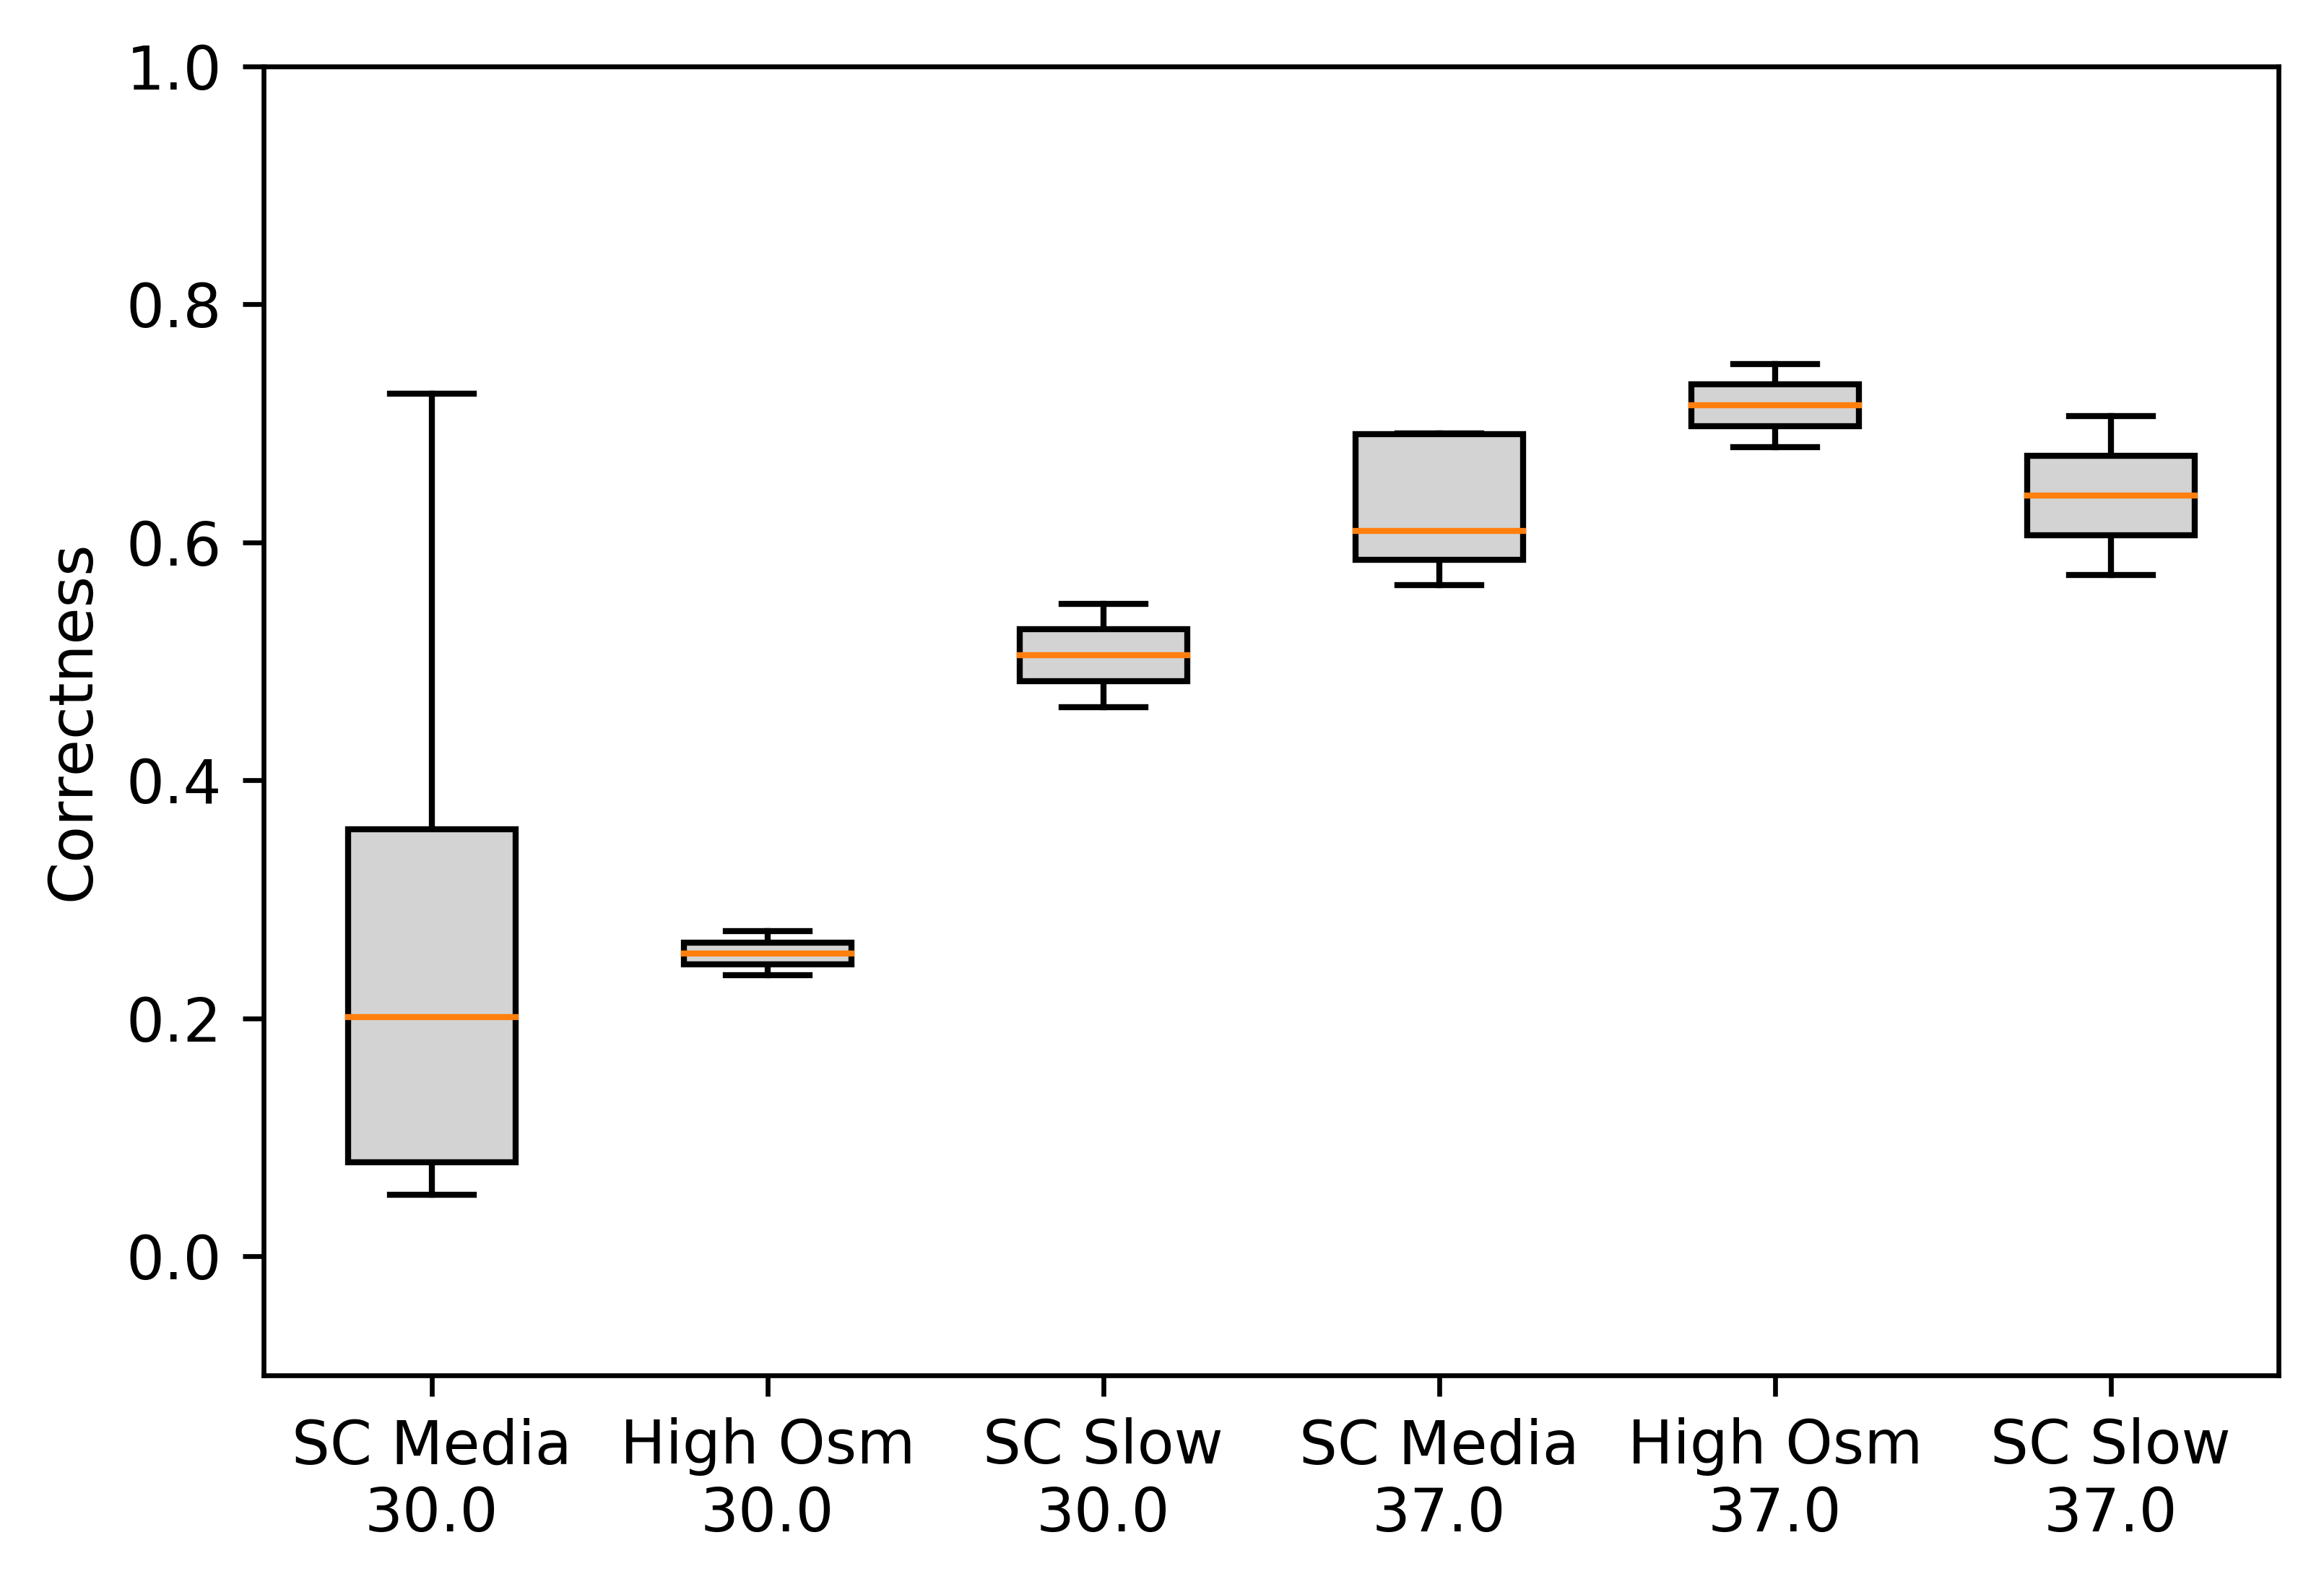

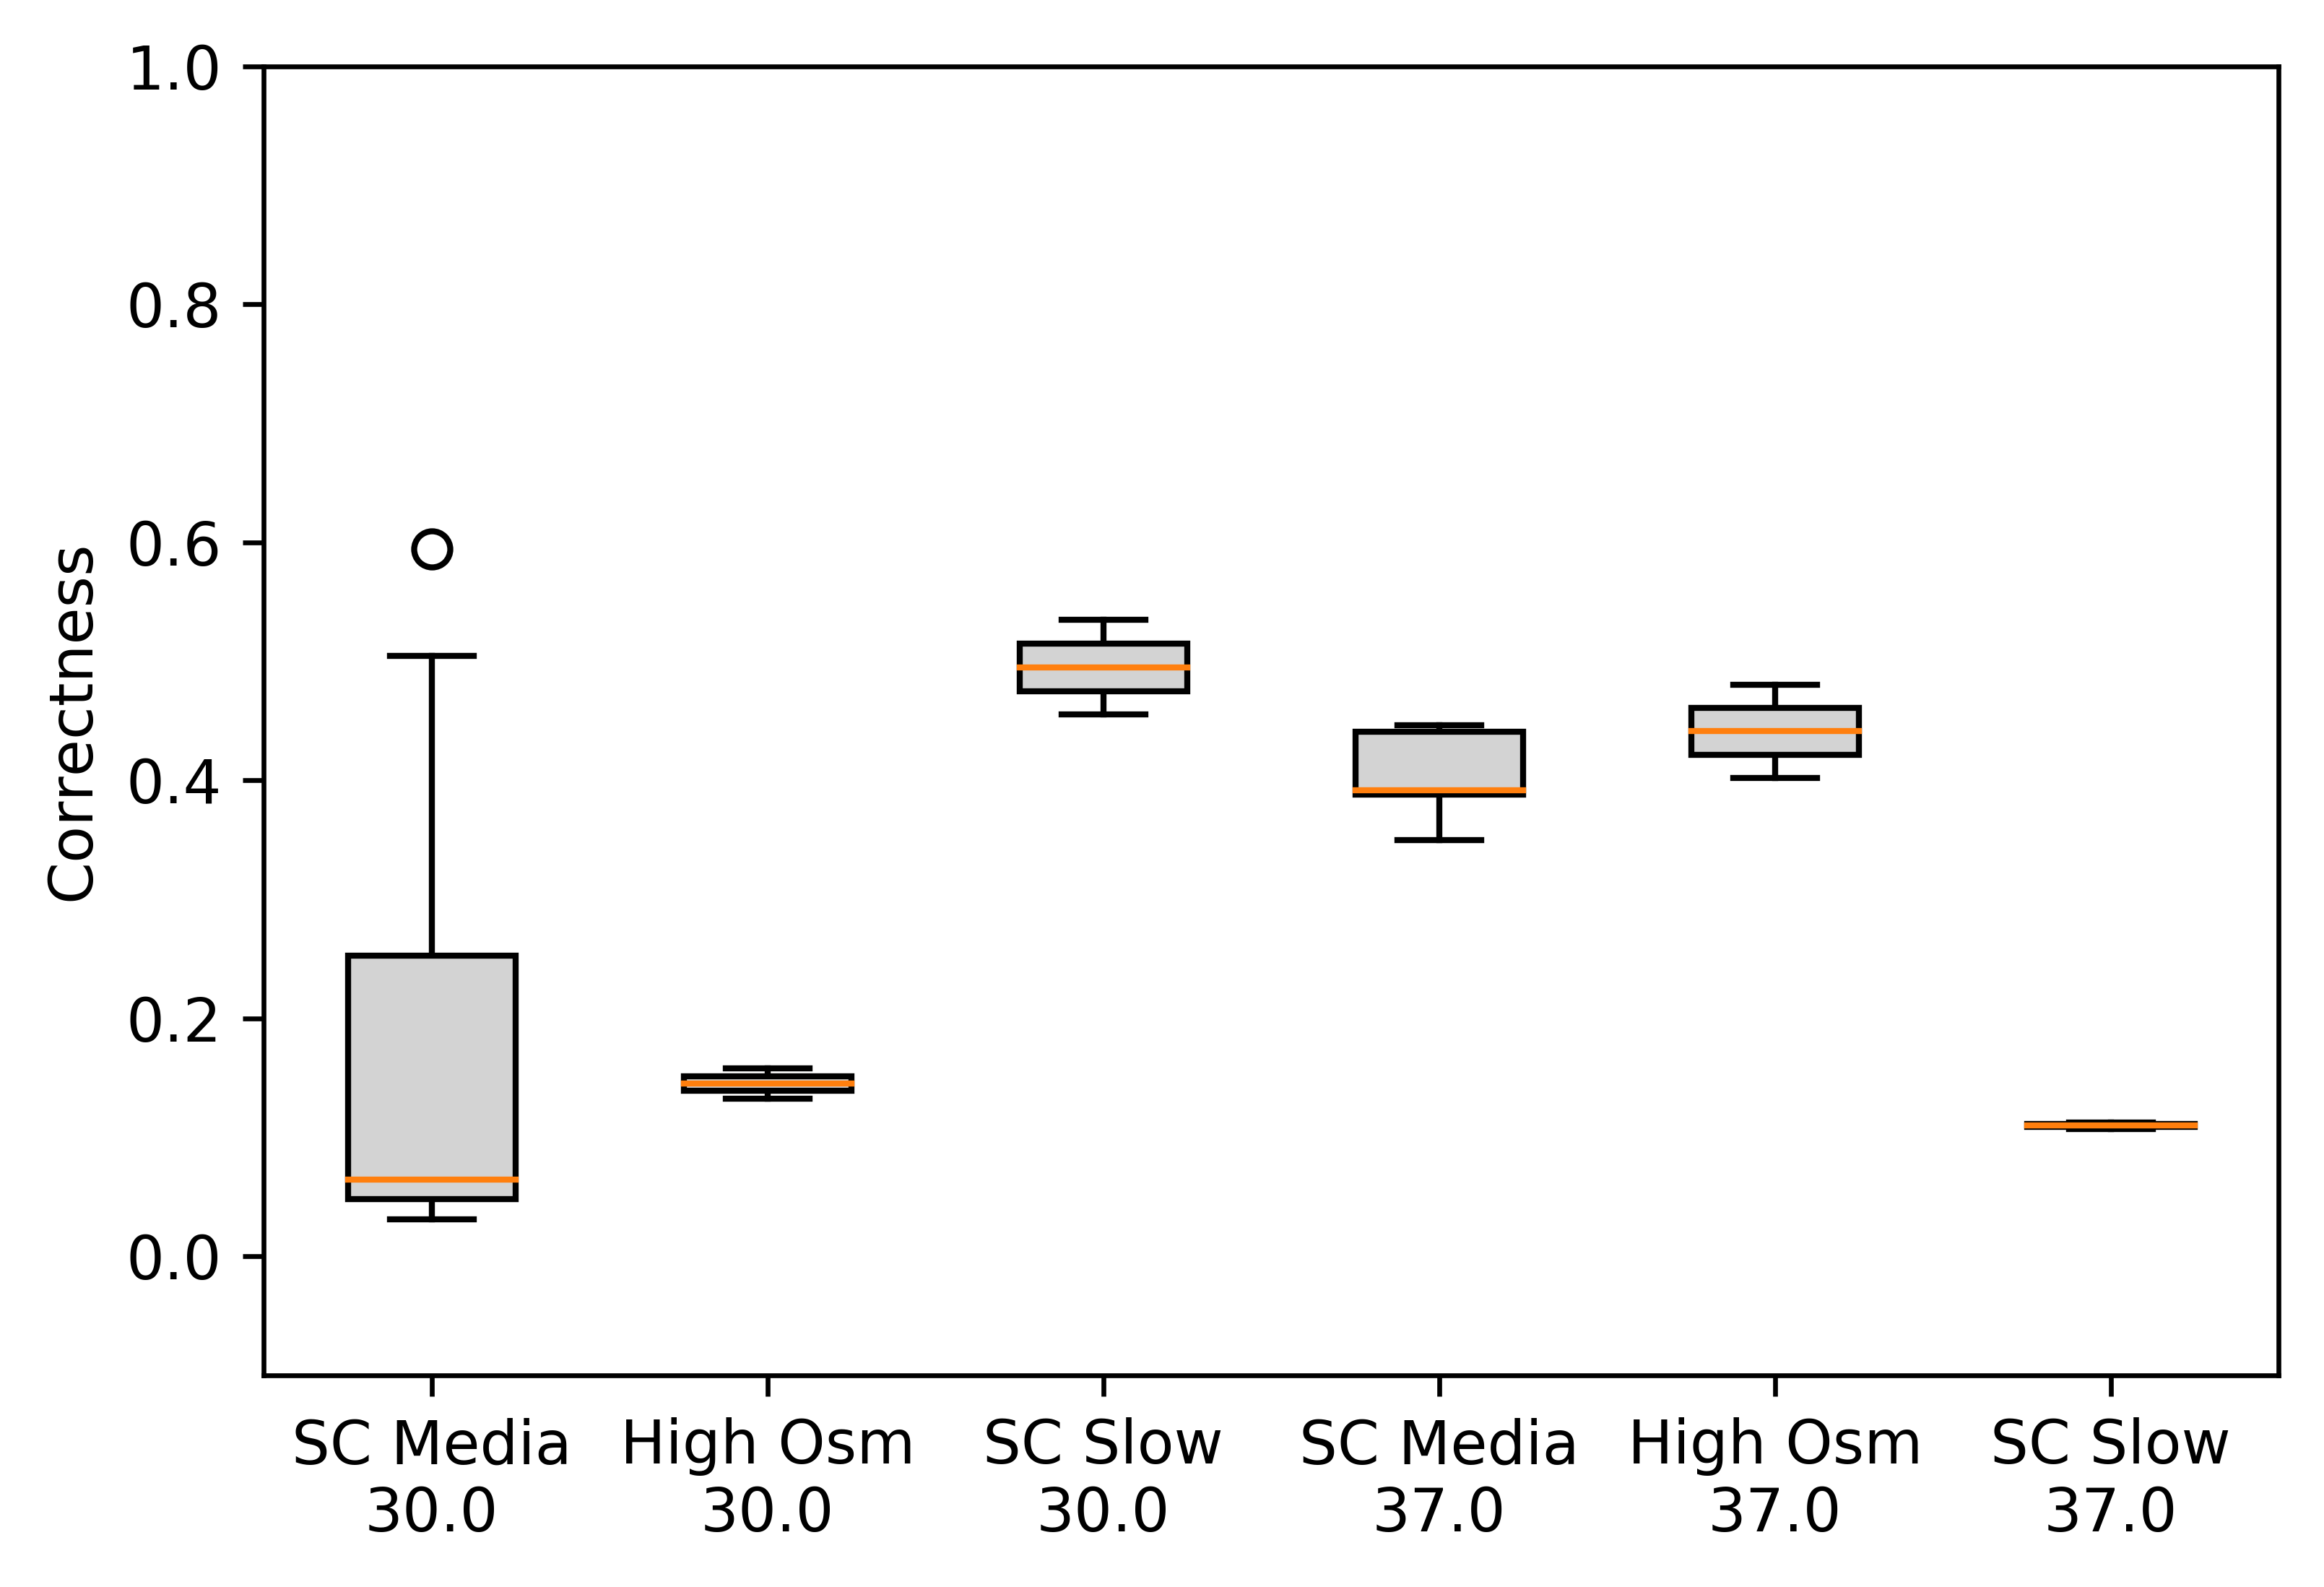

In [14]:
print("NOR")
medians = do_a_gate("NOR",correctness_columns,dfs)
cutoff=0.0
lt,gt = compare_medians(medians[0],medians[1],cutoff)
print("Percent of threshold median at least {} below classifier median: {}.".format(cutoff,lt))
print("Percent of threshold median above classifier median: {}.".format(gt))


XOR
[('SC30', (0.08848962077735041, 0.015893205065950797)), ('OSM30', (0.0022223165908646578, 0.0015714151313437697)), ('SLOW30', (0.025259997941870685, 0.017861515837454996)), ('SC37', (0.12153484306143045, 0.054352034144025424)), ('OSM37', (0.07943653022598737, 0.05617010919672582)), ('SLOW37', (0.06340310793935028, 0.04483276757221721))]
[('SC30', (0.06229844404245816, 0.011189130858043834)), ('OSM30', (0.0024905751903700132, 0.0017611026061656128)), ('SLOW30', (0.013951852902935727, 0.00986544979778307)), ('SC37', (0.04659661087044182, 0.020838637885482708)), ('OSM37', (0.024611310604782298, 0.017402824622529952)), ('SLOW37', (0.005657156949687374, 0.004000214041360546))]
Percent of threshold median at least 0.0 below classifier median: 0.6666666666666666.
Percent of threshold median above classifier median: 0.3333333333333333.


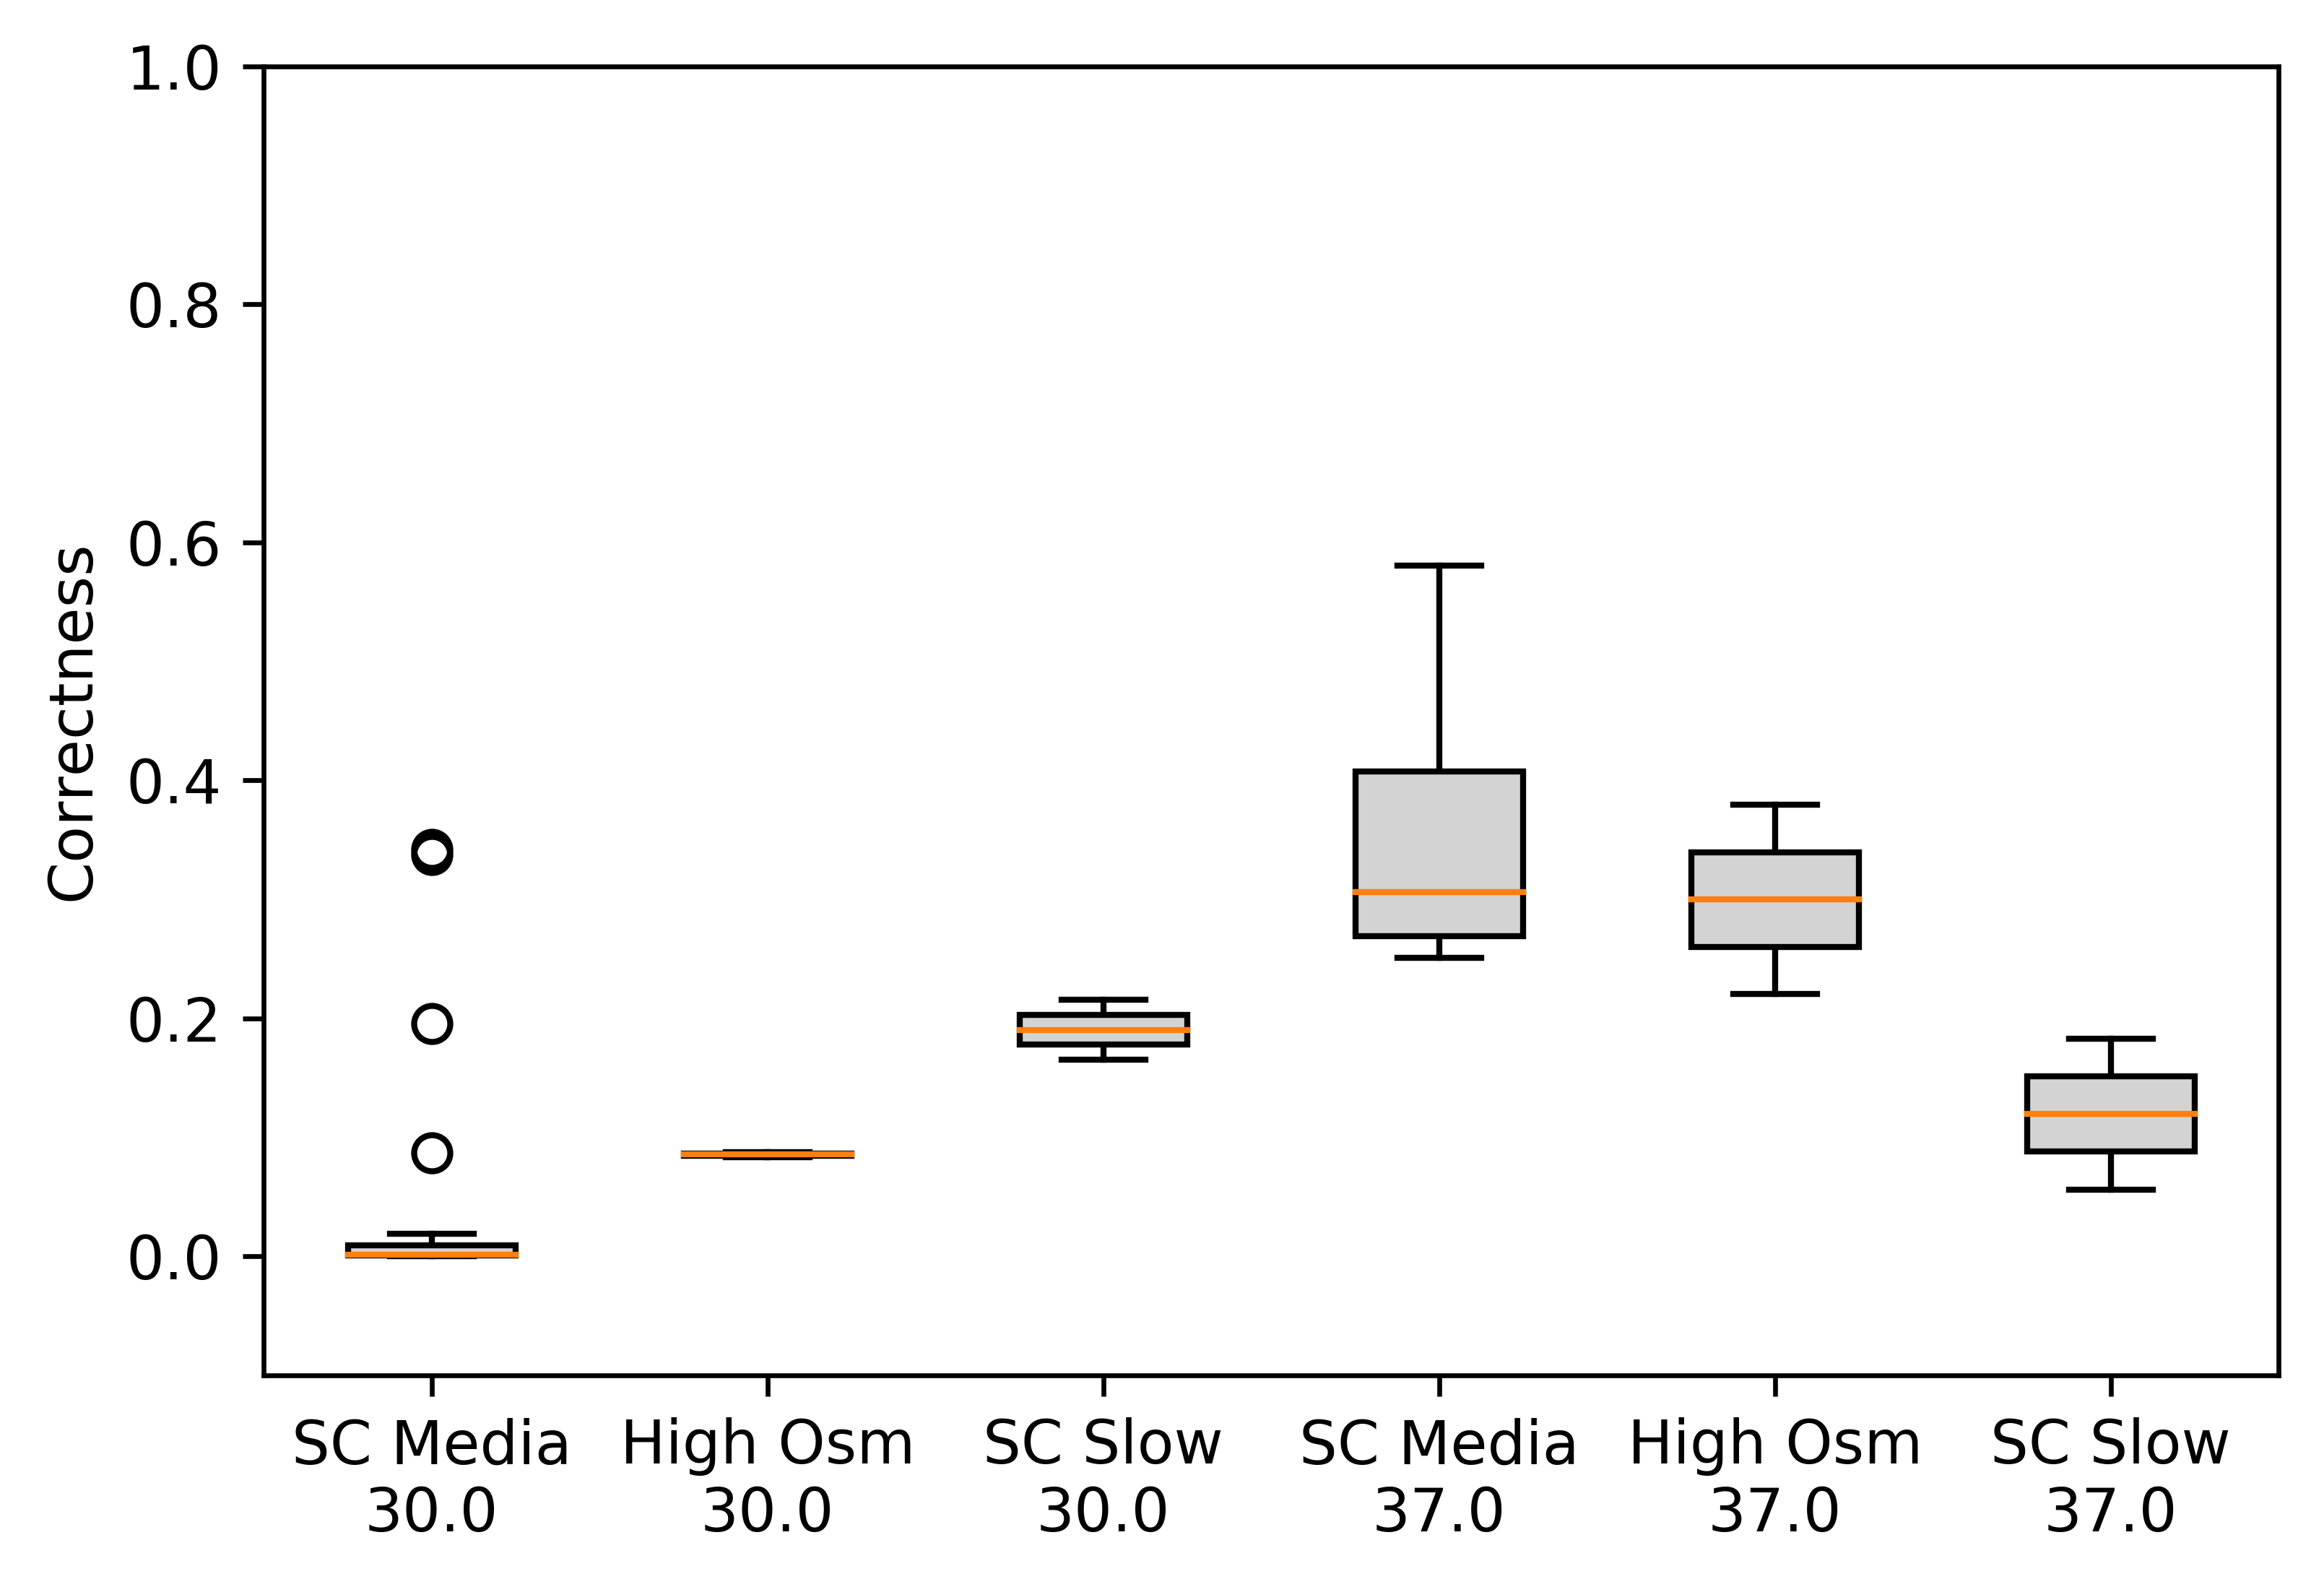

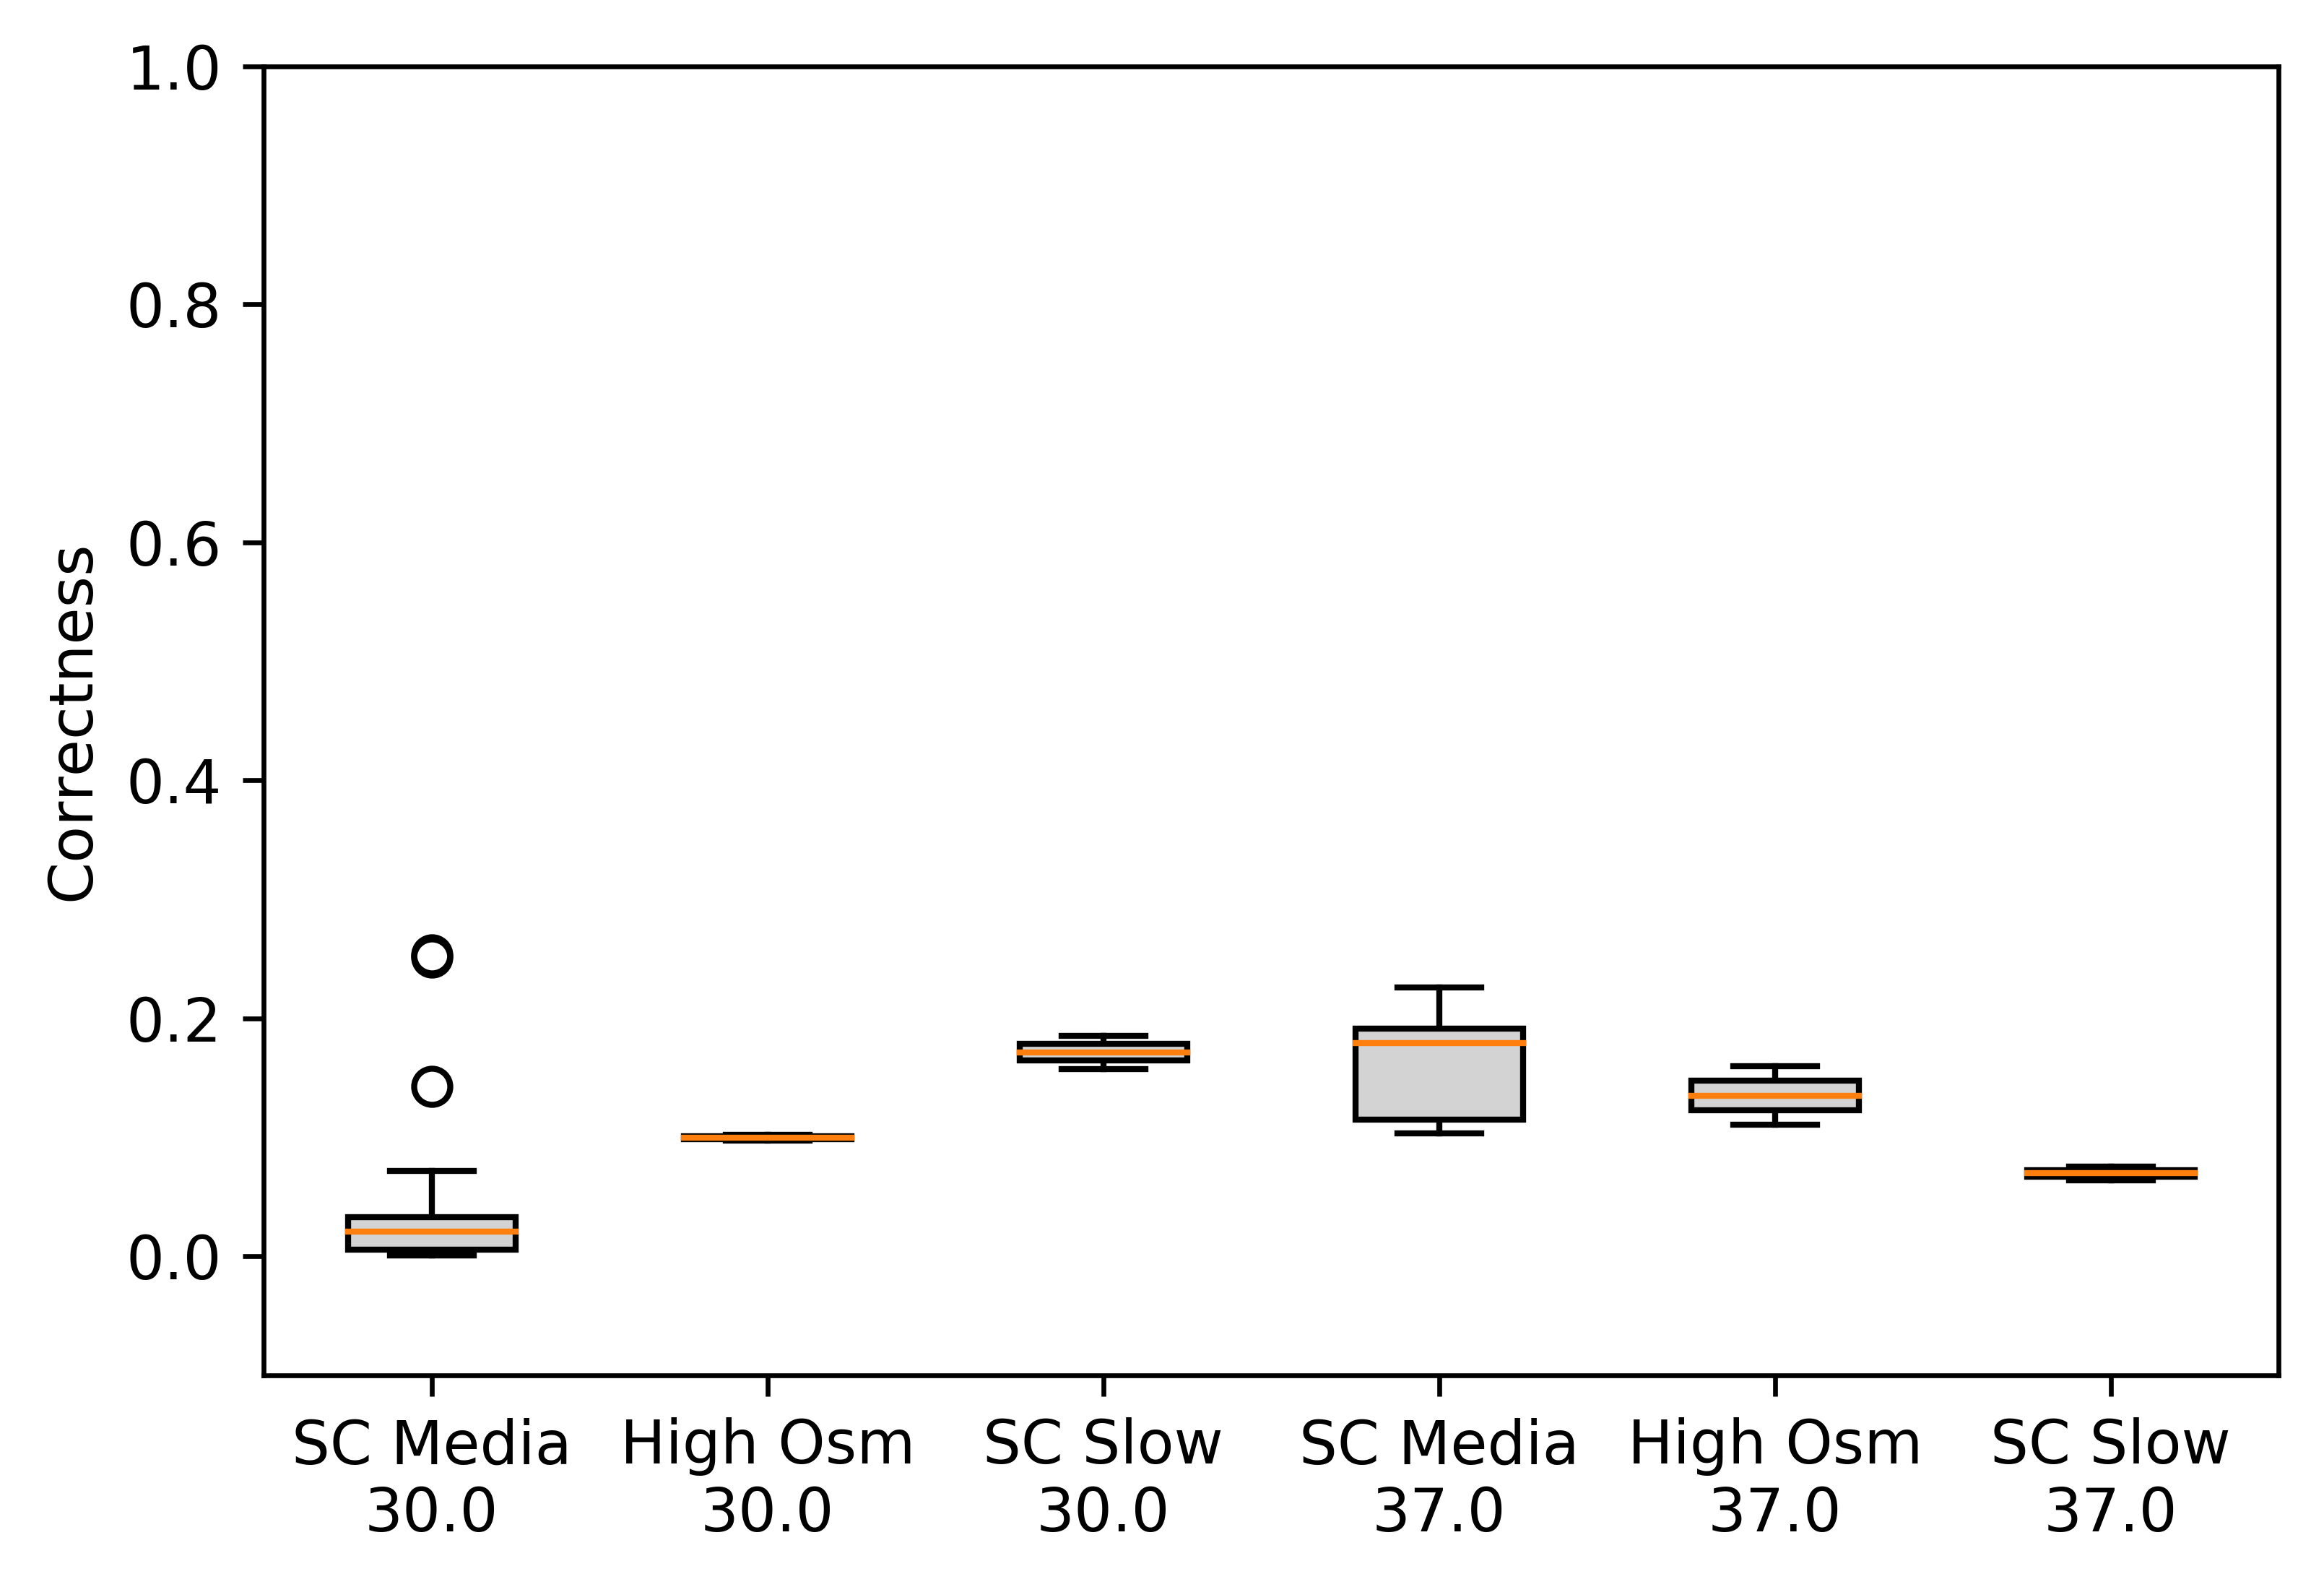

In [15]:
print("XOR")
medians = do_a_gate("XOR",correctness_columns,dfs)
cutoff=0.0
lt,gt = compare_medians(medians[0],medians[1],cutoff)
print("Percent of threshold median at least {} below classifier median: {}.".format(cutoff,lt))
print("Percent of threshold median above classifier median: {}.".format(gt))


XNOR
[('SC30', (0.22466801231446956, 0.04035156620749549)), ('OSM30', (0.04338376254033491, 0.030676952685657732)), ('SLOW30', (nan, nan)), ('SC37', (0.09092931198451208, 0.04066482454893106)), ('OSM37', (0.03250525964762033, 0.022984689521061776)), ('SLOW37', (0.021631184716758137, 0.015295557398318485))]
[('SC30', (0.20307454032530925, 0.036473264149075646)), ('OSM30', (0.024246138151054586, 0.017144608704196557)), ('SLOW30', (nan, nan)), ('SC37', (0.044702402254970325, 0.019991522039930706)), ('OSM37', (0.007696506917043225, 0.005442252232490433)), ('SLOW37', (0.018489745480078264, 0.013074224411376656))]


/Users/b37v456/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/b37v456/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/b37v456/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/b37v456/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/b37v456/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Percent of threshold median at least 0.0 below classifier median: 0.8.
Percent of threshold median above classifier median: 0.2.


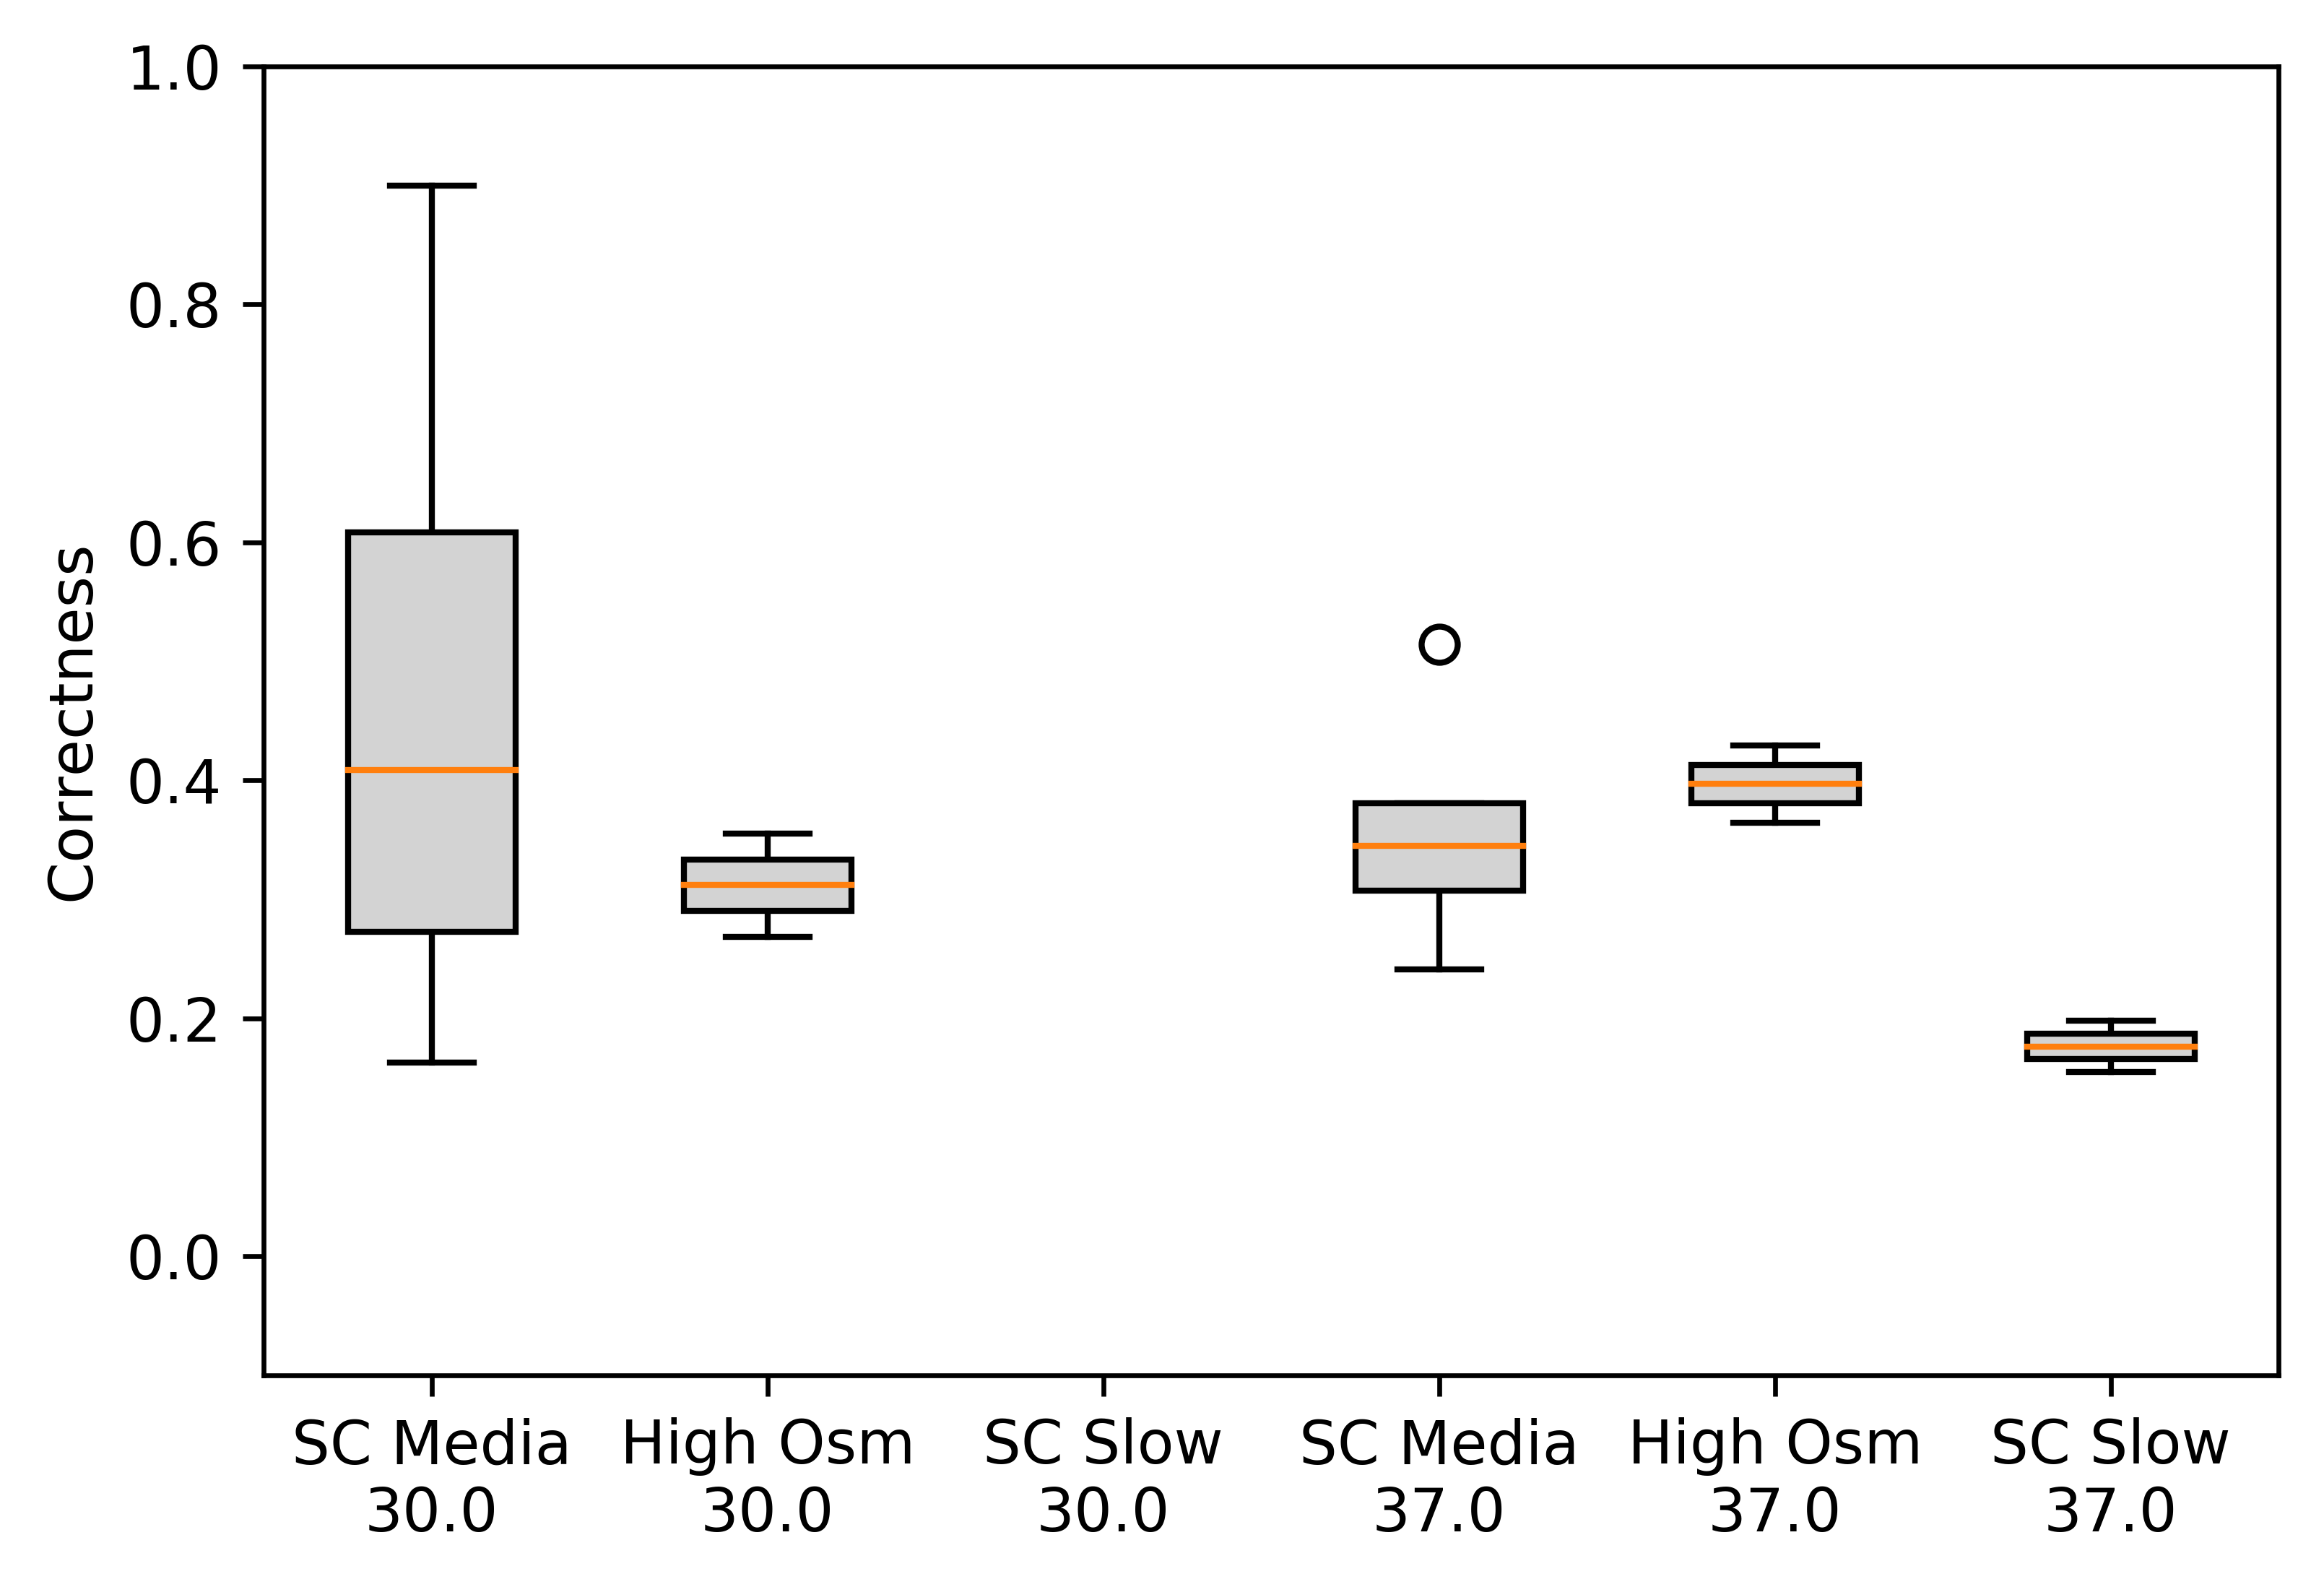

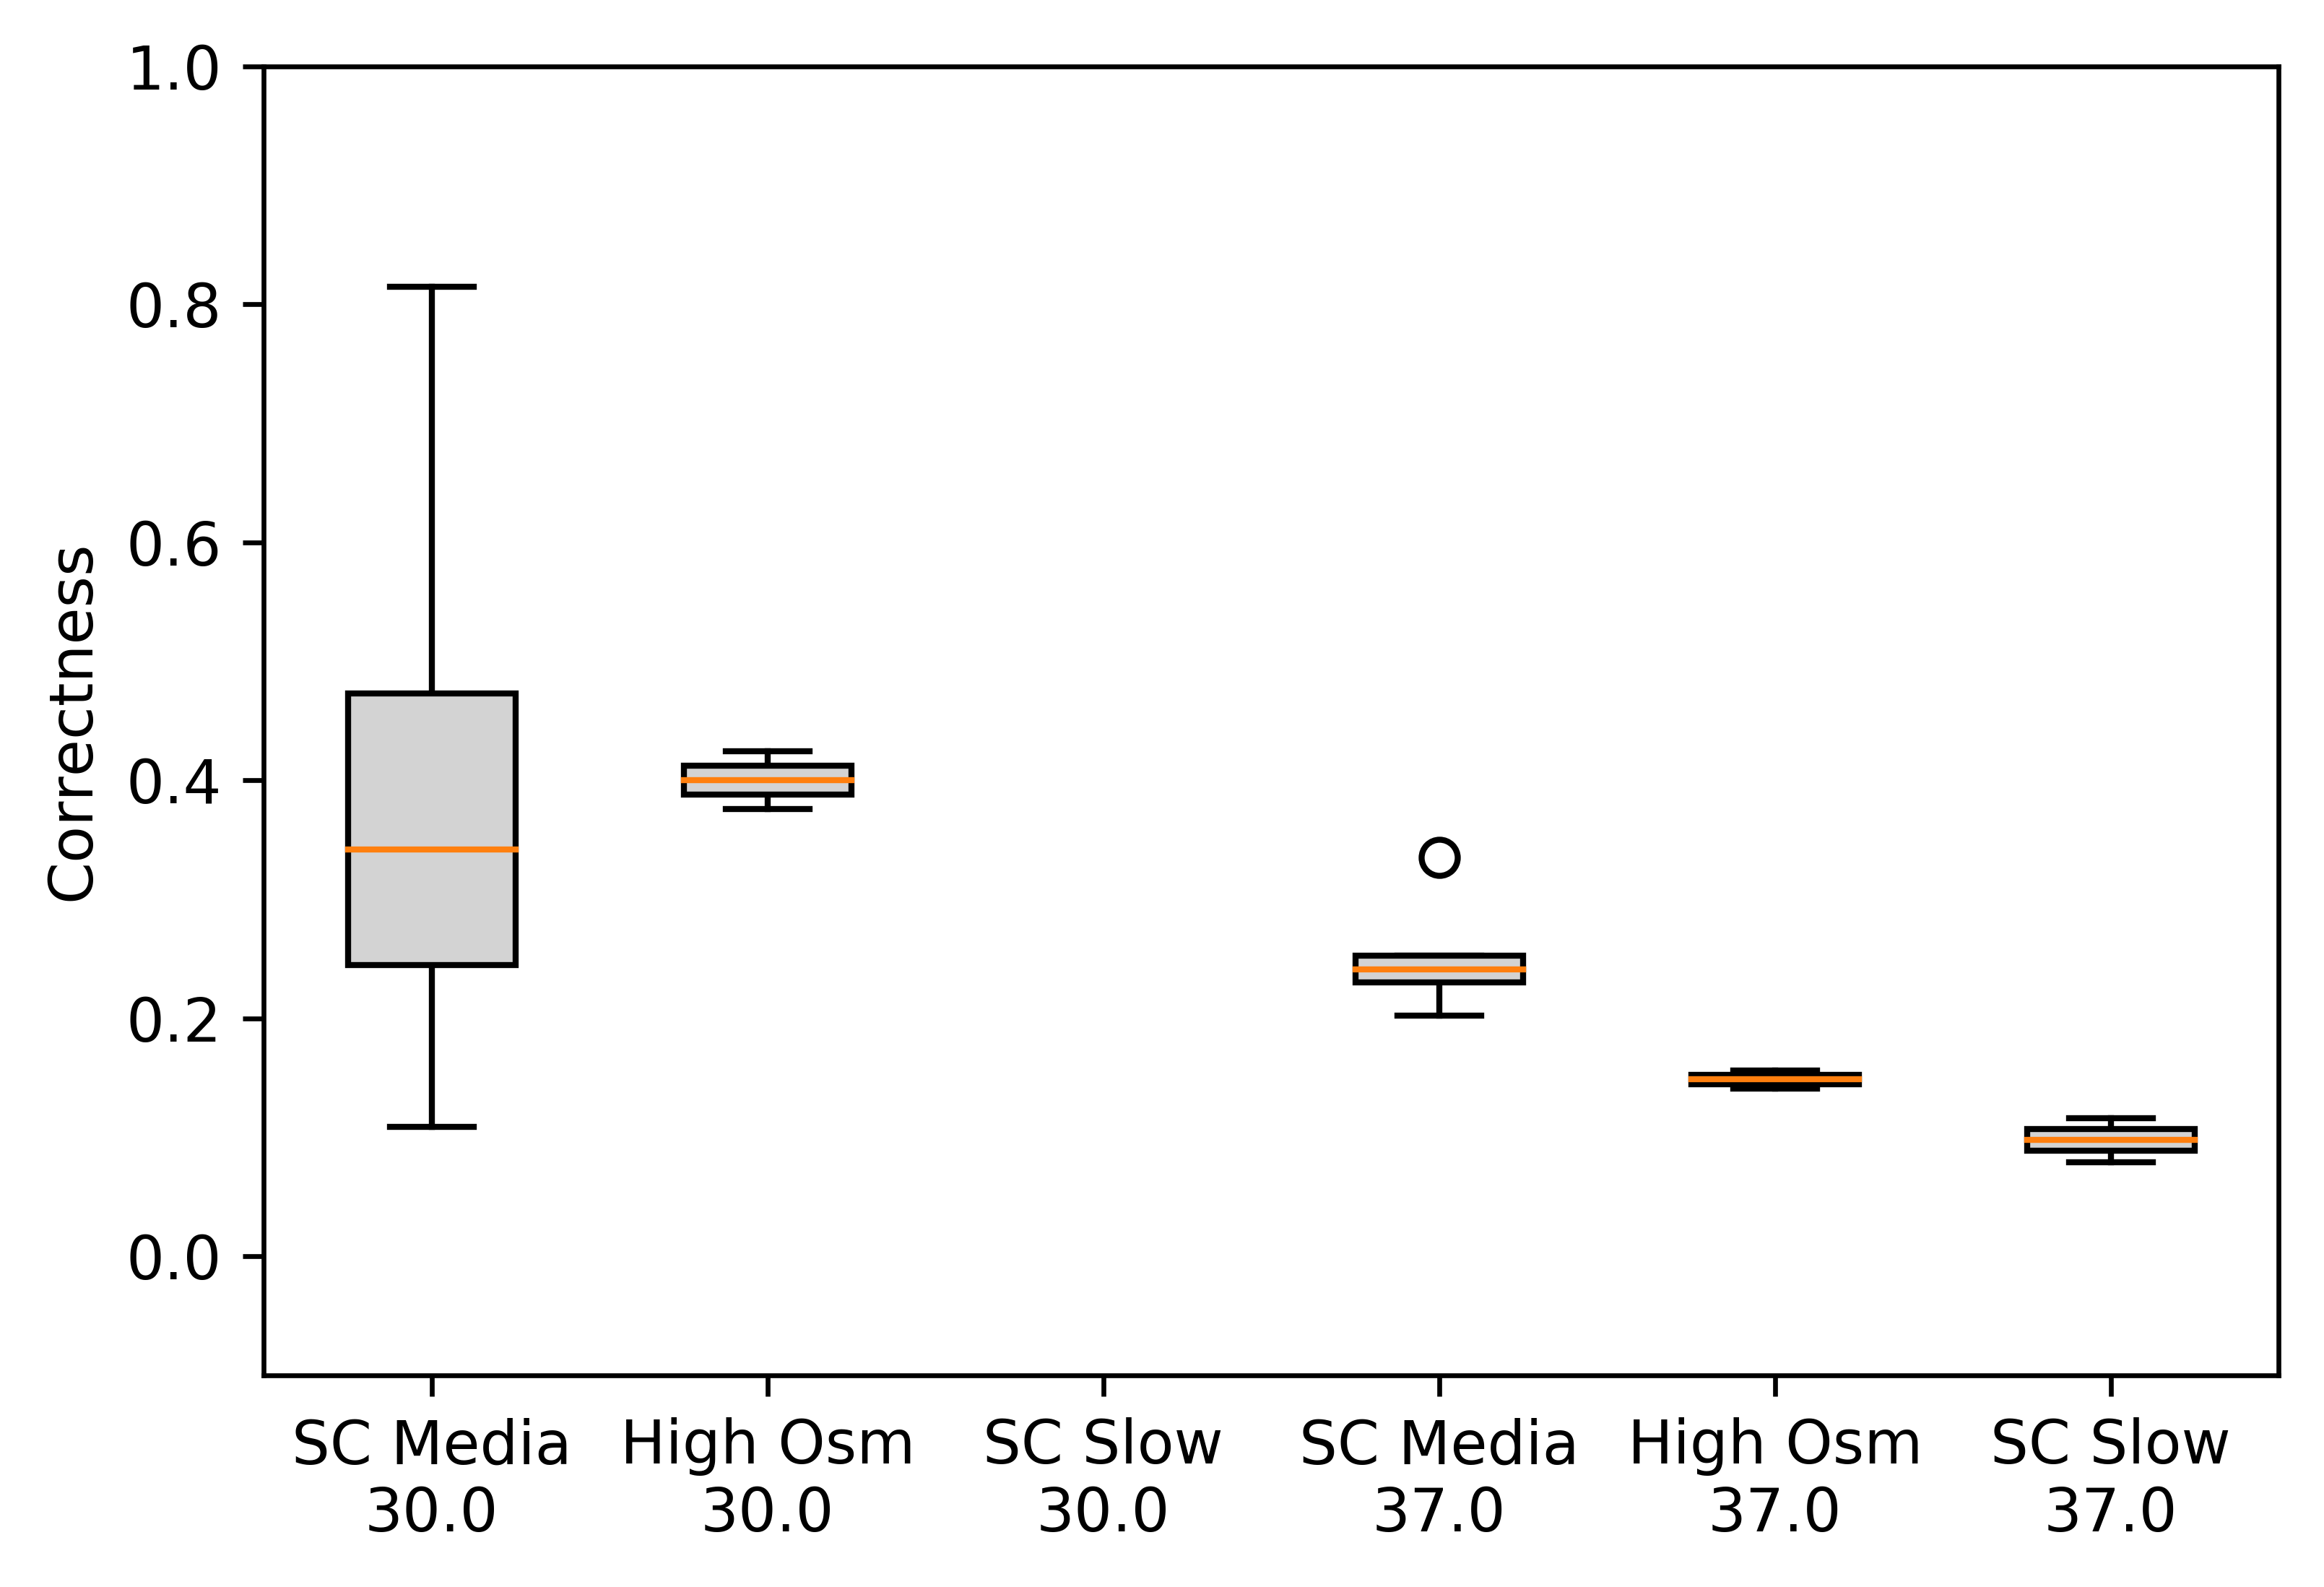

In [16]:
print("XNOR")
medians = do_a_gate("XNOR",correctness_columns,dfs)
cutoff=0.0
lt,gt = compare_medians(medians[0],medians[1],cutoff)
print("Percent of threshold median at least {} below classifier median: {}.".format(cutoff,lt))
print("Percent of threshold median above classifier median: {}.".format(gt))
